#####Libraries
***

In [1]:
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.cluster import KMeans
# from scipy.cluster.vq import kmeans,vq
from sklearn.preprocessing import Normalizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 17.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
# pip install TA-lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=$HOME
!make
!make install

!TA_LIBRARY_PATH=~/lib TA_INCLUDE_PATH=~/include pip install ta-lib

--2022-10-31 08:58:03--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-10-31 08:58:03--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-10-31 08:58:03--  http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cfhcable.dl.s

In [3]:
import talib as ta


#####Functions
***

In [4]:
def RPS_calculation(hist_data, submission, asset_no):
    if hist_data.shape[0]<=asset_no:
        return np.nan    
    
    asset_id = pd.unique(hist_data.symbol)
    
    for i in range(len(pd.unique(hist_data.date))):
        if len(hist_data[hist_data.date == pd.unique(hist_data.date)[i]])<len(asset_id):
            for asset in [x for x in asset_id if x not in hist_data[hist_data.date == pd.unique(hist_data.date)[i]].symbol.values]:
                right_price = hist_data[hist_data.symbol==asset].sort_values(by='date')
                right_price = right_price[right_price.date <= pd.unique(hist_data.date)[i]]
                right_price = right_price.price.iloc[-1]
                hist_data = hist_data.append({'date' : pd.unique(hist_data.date)[i],
                                               'symbol' : asset,
                                               'price' : right_price}, ignore_index=True)

    #Compute percentage returns
    asset_id = sorted(asset_id) 

    #Compute percentage returns
    returns = pd.DataFrame(columns = ["ID", "Return"])
    
    min_date = min(hist_data.date)
    max_date = max(hist_data.date)
    
    for i in range(0,len(asset_id)):
        temp = hist_data.loc[hist_data.symbol==asset_id[i]]
        
        open_price = float(temp.loc[temp.date==min_date].price)
        close_price = float(temp.loc[temp.date==max_date].price)
        
        returns = returns.append({'ID': temp.symbol.iloc[0], 
                                'Return': (close_price - open_price)/open_price}, ignore_index=True)
    
    #Define the relevant position of each asset
    ranking = pd.DataFrame(columns=["ID", "Position", "Return"])
    ranking.ID = list(asset_id)
    ranking.Return = returns.Return
    ranking.Position = ranking.Return.rank(method = 'min')
    
    #Handle Ties
    Series_per_position = pd.DataFrame(columns=["Position","Series", "Rank", "Rank1", "Rank2","Rank3", "Rank4", "Rank5"])
    Series_per_position.Position = list(pd.unique(ranking.Position.sort_values(ascending=True)))
    temp = ranking.Position.value_counts()
    temp = pd.DataFrame(zip(temp.index, temp), columns = ["Rank", "Occurencies"])
    temp = temp.sort_values(by = ["Rank"],ascending=True)
    Series_per_position.Series = list(temp.Occurencies)
    Series_per_position

    total_ranks = Series_per_position.Position.values[-1]
    for i in range(0,Series_per_position.shape[0]):
    
        start_p = Series_per_position.Position[i]
        end_p = Series_per_position.Position[i] + Series_per_position.Series[i]
        temp = pd.DataFrame(columns = ["Position","Rank", "Rank1", "Rank2", "Rank3", "Rank4","Rank5"])
        temp.Position = list(range(int(start_p),int(end_p)))

        if(temp.loc[temp.Position.isin(list(range(1,int(0.2*total_ranks+1))))].empty==False):
            temp.loc[temp.Position.isin(list(range(1,int(0.2*total_ranks+1))))] = temp.loc[temp.Position.isin(list(range(1,int(0.2*total_ranks+1))))].assign(Rank=1)
            temp.loc[temp.Position.isin(list(range(1,int(0.2*total_ranks+1))))] = temp.loc[temp.Position.isin(list(range(1,int(0.2*total_ranks+1))))].assign(Rank1=1.0)

        elif(temp.loc[temp.Position.isin(list(range(int(0.2*total_ranks+1),int(0.4*total_ranks+1))))].empty==False):
            temp.loc[temp.Position.isin(list(range(int(0.2*total_ranks+1),int(0.4*total_ranks+1))))] = temp.loc[temp.Position.isin(list(range(int(0.2*total_ranks+1),int(0.4*total_ranks+1))))].assign(Rank=2)
            temp.loc[temp.Position.isin(list(range(int(0.2*total_ranks+1),int(0.4*total_ranks+1))))] = temp.loc[temp.Position.isin(list(range(int(0.2*total_ranks+1),int(0.4*total_ranks+1))))].assign(Rank2=1.0)

        elif(temp.loc[temp.Position.isin(list(range(int(0.4*total_ranks+1),int(0.6*total_ranks+1))))].empty==False):
            temp.loc[temp.Position.isin(list(range(int(0.4*total_ranks+1),int(0.6*total_ranks+1))))] = temp.loc[temp.Position.isin(list(range(int(0.4*total_ranks+1),int(0.6*total_ranks+1))))].assign(Rank=3)
            temp.loc[temp.Position.isin(list(range(int(0.4*total_ranks+1),int(0.6*total_ranks+1))))] = temp.loc[temp.Position.isin(list(range(int(0.4*total_ranks+1),int(0.6*total_ranks+1))))].assign(Rank3=1.0)

        elif(temp.loc[temp.Position.isin(list(range(int(0.6*total_ranks+1),int(0.8*total_ranks+1))))].empty==False):
            temp.loc[temp.Position.isin(list(range(int(0.6*total_ranks+1),int(0.8*total_ranks+1))))] = temp.loc[temp.Position.isin(list(range(int(0.6*total_ranks+1),int(0.8*total_ranks+1))))].assign(Rank=4)
            temp.loc[temp.Position.isin(list(range(int(0.6*total_ranks+1),int(0.8*total_ranks+1))))] = temp.loc[temp.Position.isin(list(range(int(0.6*total_ranks+1),int(0.8*total_ranks+1))))].assign(Rank4=1.0)

        elif(temp.loc[temp.Position.isin(list(range(int(0.8*total_ranks+1),int(total_ranks+1))))].empty==False):
            temp.loc[temp.Position.isin(list(range(int(0.8*total_ranks+1),int(total_ranks+1))))] = temp.loc[temp.Position.isin(list(range(int(0.8*total_ranks+1),int(total_ranks+1))))].assign(Rank=5)
            temp.loc[temp.Position.isin(list(range(int(0.8*total_ranks+1),int(total_ranks+1))))] = temp.loc[temp.Position.isin(list(range(int(0.8*total_ranks+1),int(total_ranks+1))))].assign(Rank5=1.0)
        temp = temp.fillna(0)
        Series_per_position.iloc[i,2:Series_per_position.shape[1]] = temp.mean(axis = 0).iloc[1:temp.shape[1]]
    
    Series_per_position = Series_per_position.drop('Series', axis = 1)
    ranking = pd.merge(ranking,Series_per_position, on = "Position")
    ranking = ranking[["ID", "Return", "Position", "Rank", "Rank1", "Rank2", "Rank3", "Rank4", "Rank5"]]
    ranking = ranking.sort_values(["Position"])
    # print(ranking)
    #Evaluate submission
    rps_sub = []
    #for aid in list((pd.unique(ranking.ID))):
    for aid in asset_id:
        
        target = np.cumsum(ranking.loc[ranking.ID==aid].iloc[:,4:9].values).tolist()
        frc = np.cumsum(submission.loc[submission.ID==aid].iloc[:,1:6].values).tolist()
        rps_sub.append(np.mean([(a - b)**2 for a, b in zip(target, frc)]))
    rps_sub_new=[x for x in rps_sub if np.isnan(x) == False]
    # print('new_rps:',rps_sub_new)
    submission["RPS"] = rps_sub_new
    output = {'RPS' : np.mean(rps_sub),
              'details' : submission}

    return(output)

In [5]:
def create_historical(prob):
  prob=prob.rename_axis("symbol", axis="columns")
  prob=prob.T
  prob['date']=prob.columns.date[0]
  prob.columns = ['price', 'date']
  prob=prob.reset_index()
  prob=prob[['symbol','date','price']]
  return prob

In [6]:
def predictions(model,assets,stock,k):
  prob=dict()

  for j in assets:
      print(j)
      tmp=[]
      df=stock[j]
      df1=df.dropna()
      X= df1.iloc[:,5:k]
      print(X) #it has all the days
      # print(df1)
      y= df1['Rank']
      X_train= X.iloc[:-60] #only the days of one year until 3/01
      # print(X_train)
      Y_train= y.iloc[:-60]
      # print(Y_train)
      model.fit(X_train,Y_train)
      #now each day we will use the models to predict 
      for i in range(59,0,-1): #from 4/01 and later -->predictions
        X_validation=X.iloc[-(i+1):-i] 
        # print(X_validation)
        Y_validation= y.iloc[-(i+1):-i]
        # print(Y_validation.index) 
        probability= model.predict_proba(X_validation)
        # print(probability[0])
        tmp.append(probability[0])
      X_validation=X.tail(1) 
      # print(X_validation)
      Y_validation= y.tail(1)
      print(Y_validation.index) 
      probability= model.predict_proba(X_validation)
      print(probability[0])
      tmp.append(probability[0])
      prob[j]=tmp
  return prob

In [7]:
def RPS_data(prob_final,rd):
  RPS=pd.DataFrame()

  # RPS=RPS.drop('date',axis=1)
  # print(RPS.index[2])
  for k in prob_final.index: #for everyday of a stock->index
    prob=pd.DataFrame()
    prob1=pd.DataFrame()
    predic=pd.DataFrame()
    if(prob_final['date'][k]!=prob_final['date'].tail(1).values): #if it's not for the last day 
      #for historical data of two days 
      prob=rd.loc[(rd.index.date==prob_final['date'][k])]
      prob1=rd.loc[ (rd.index.date==prob_final['date'][k+1])]
      prob=create_historical(prob)
      prob1=create_historical(prob1)
      hist_data=prob.append(prob1)
      predic=prob_final.loc[prob_final['date']==prob_final['date'][k]] #find predictions of this day
      predic=predic.drop('date',axis=1)
      # print(predic)
      data=pd.DataFrame(index=predic.columns)
      data=data.reset_index()
      # print(len(data))
      data[['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4','Rank 5']]=(0,0,0,0,0)
      for i in range(len(np.array_split(predic.values[0],len(data)+1))-1):
        data.loc[i,['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4','Rank 5']]=np.array_split(predic.values[0],len(data))[i][0]
      data.columns = ['ID','Rank 1', 'Rank 2', 'Rank 3', 'Rank 4','Rank 5']
      # print(data)

      #now we have data->predictions and hist_data->historical data so now we can call the RPS
      rps=RPS_calculation(hist_data = hist_data , submission = data , asset_no=len(data)-1)['details']
      # print(rps) ->rps for every stock for one day 
      # print(rps['RPS'])
      tmp=pd.DataFrame(rps['RPS'].values).T
      # print(tmp.T)
      RPS=RPS.append(tmp,ignore_index=True)
      # print(RPS[RPS.index==k])

      
    else:
      #for the last day
      prob=rd.loc[(rd.index.date==prob_final['date'][k])]
      prob1=rd.loc[ (rd.index.date==rd.index.date[-1])]
      prob=create_historical(prob)
      prob1=create_historical(prob1)
      hist_data=prob.append(prob1)
      print(hist_data)
      predic=prob_final.loc[prob_final['date']==prob_final['date'][k]] #find predictions of this day
      predic=predic.drop('date',axis=1)
      print(predic)
      data=pd.DataFrame(index=predic.columns)
      data=data.reset_index()
      # print(data)
      data[['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4','Rank 5']]=(0,0,0,0,0)
      for i in range(len(np.array_split(predic.values[0],len(data)+1))-1):
        data.loc[i,['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4','Rank 5']]=np.array_split(predic.values[0],len(data))[i][0]
      data.columns = ['ID','Rank 1', 'Rank 2', 'Rank 3', 'Rank 4','Rank 5']
      print(data)

      #now we have data->predictions and hist_data->historical data so now we can call the RPS
      rps=RPS_calculation(hist_data = hist_data , submission = data,asset_no=len(data)-1)['details']
      # print(rps) ->rps for every stock for one day 
      # print(rps['RPS'])
      tmp=pd.DataFrame(rps['RPS'].values).T
      # print(tmp.T)
      RPS=RPS.append(tmp,ignore_index=True)              
  return RPS

In [8]:
def create_RPS(prob_final,RPS,id):
  d=prob_final['date']
  # print('ok2')
  name=prob_final.columns[:-1]
  # print('ok3')
  # print(np.split(name.values,len(name)))
  # print(d.values)
  RPS['date']=d.values
  # print('ok4')
  RPS=RPS.set_index('date')
  RPS.columns=id
  return RPS

##### Load Dataset
***

In [9]:
#φτιάχνω τη λίστα με τα assets μου -> 50 μετοχές 
#διόρθωση : θα βγάλω τυχαία άλλες 4 μετοχές μαζί με την OGN επειδή δεν έχει το ίδιο μέγεθος με τις άλλες 
#βγάζω OGN ,WRK,HST,CE,ACN
assets= ["ABBV","AEP","AIZ","ALLE","AMAT","AMP","AMZN","AVB","AVY",   
  "AXP","BDX","BF-B","BMY","BR","CARR","CDW","CHTR","CNC",   
  "CNP","COP","CTAS","CZR","DG","DPZ","DRE","DXC","META","FTV",    #####CHANGE FROM FB TO META
  "GOOG","GPC","HIG","JPM","KR","PG","PPL","PRU",   
  "PYPL","RE","ROL","ROST","UNH","URI","V","VRSK","XOM"]
#άρα πρέπει να κατεβάσουμε όλα τα adj close για όλες τις τιμές όλων των μετοχών και να κάνουμε απόλυτο ranking και σε 5 κλασεις (targets)
r=pd.DataFrame(index=pdr.get_data_yahoo(assets[0],'2021-01-01','2022-04-01')['Adj Close'].index)
#παίρνω τιμές για ένα χρόνο 
for i in assets:
  # print('i metoxi me onoma:',i,'exei megethos',pdr.get_data_yahoo(i,'2021-01-01','2022-04-01')['Adj Close'].count())
  temp= pdr.get_data_yahoo(i,'2021-01-01','2022-04-01')['Adj Close']
  temp=temp.dropna()
  r[i]=temp.values
#φτιάχνω ένα αντίγραφο με τις τιμές για να το έχω 
rd=pd.DataFrame(r)
rd1= rd.pct_change().shift(-1)
rd1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,ABBV,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,AXP,...,PRU,PYPL,RE,ROL,ROST,UNH,URI,V,VRSK,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.010341,-0.001349,0.000303,0.001922,0.031426,-0.005848,0.010004,-0.002894,0.002173,0.005337,...,0.009686,0.012892,-0.008242,0.016475,0.000854,-0.013448,0.025778,-0.014925,-0.004485,0.048193
2021-01-05,-0.008639,0.007982,0.043890,0.022755,0.013728,0.057377,-0.024897,0.026826,0.038232,0.036993,...,0.059243,-0.034396,0.059276,0.016465,0.043697,0.041966,0.089060,-0.008811,-0.009457,0.025517
2021-01-06,0.010703,-0.026681,0.010076,0.026340,0.041066,0.012087,0.007577,-0.013628,0.031193,-0.007910,...,-0.004406,0.036194,0.007177,0.016705,-0.002208,0.016033,0.031690,0.005597,0.004549,0.007846
2021-01-07,0.005248,-0.008887,-0.005239,-0.003488,0.010575,0.007095,0.006496,0.008787,-0.038226,0.000986,...,-0.007990,0.031569,-0.009902,0.015683,0.003196,-0.004493,-0.017115,0.007670,-0.000348,0.011121
2021-01-08,0.016314,-0.005052,-0.005772,0.002917,0.025115,0.000149,-0.021519,-0.006690,0.029282,-0.005912,...,0.000991,-0.020457,-0.007198,0.002696,-0.012581,-0.007265,-0.010379,-0.011882,-0.015082,0.030357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,0.003967,0.007951,-0.004391,0.010508,0.004378,-0.011219,0.025593,0.011123,0.002079,-0.003048,...,-0.006619,0.021185,-0.004147,0.018042,0.014852,0.000331,-0.000742,0.010713,0.017308,-0.028052
2022-03-28,0.001296,0.011065,-0.012849,0.013835,0.027459,0.003600,0.001920,0.033081,0.031124,0.006537,...,0.006663,0.043126,0.016153,0.021209,0.043578,-0.004813,0.004953,0.033292,0.015123,-0.005313
2022-03-29,0.009681,0.007397,0.004743,-0.014776,-0.039876,-0.005189,-0.017801,-0.018389,-0.011571,-0.006180,...,-0.004633,-0.022198,0.007072,0.008250,-0.030769,0.019756,-0.016457,-0.018280,0.010102,0.017118


In [10]:
rd2=rd1.rank(axis=1,method='first')
rd2=rd2.dropna()
rd2.astype(int)
jk=rd2.copy()
jk.astype(int)

,ABBV,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,AXP,...,PRU,PYPL,RE,ROL,ROST,UNH,URI,V,VRSK,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,34,14,15,21,41,9,33,12,22,25,...,32,36,6,38,17,5,40,3,11,44
2021-01-05,8,14,37,25,20,40,3,28,31,29,...,41,1,42,21,36,35,44,7,6,26
2021-01-06,25,2,23,36,44,28,20,3,40,8,...,9,43,19,30,11,29,41,18,16,21
2021-01-07,28,8,13,17,37,31,30,34,1,22,...,11,45,6,42,26,14,3,33,19,38
2021-01-08,39,23,22,29,42,26,5,20,43,21,...,27,7,16,28,10,15,13,11,9,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-24,21,16,27,4,3,28,22,40,45,24,...,38,2,37,25,5,8,36,19,7,42
2022-03-25,22,27,9,31,23,4,45,36,19,13,...,8,42,11,41,38,18,16,32,40,2
2022-03-28,7,20,2,24,36,11,9,41,39,14,...,15,43,26,33,44,5,12,42,25,4


In [11]:
def rank_data(df1):
  for i in range(len(df1.index)):
    d=df1.loc[df1.index[i]]  #της κάθε μέρας d[1] δίνει μόνο τις τιμές 
    #print(d)
    d=d.sort_values()
    d[0:9]=1
    d[9:18]=2
    d[18:27]=3
    d[27:36]=4
    d[36:45]=5
    df1.loc[df1.index[i]]=d
    #print(df1.loc[df1.index[i]])
    #print(d)
  df1=df1.astype(int)
  return df1
r5=rd2.copy()
rd3=rank_data(r5)
rd3

,ABBV,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,AXP,...,PRU,PYPL,RE,ROL,ROST,UNH,URI,V,VRSK,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,4,2,2,3,5,1,4,2,3,3,...,4,4,1,5,2,1,5,1,2,5
2021-01-05,1,2,5,3,3,5,1,4,4,4,...,5,1,5,3,4,4,5,1,1,3
2021-01-06,3,1,3,4,5,4,3,1,5,1,...,1,5,3,4,2,4,5,2,2,3
2021-01-07,4,1,2,2,5,4,4,4,1,3,...,2,5,1,5,3,2,1,4,3,5
2021-01-08,5,3,3,4,5,3,1,3,5,3,...,3,1,2,4,2,2,2,2,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-24,3,2,3,1,1,4,3,5,5,3,...,5,1,5,3,1,1,4,3,1,5
2022-03-25,3,3,1,4,3,1,5,4,3,2,...,1,5,2,5,5,2,2,4,5,1
2022-03-28,1,3,1,3,4,2,1,5,5,2,...,2,5,3,4,5,1,2,5,3,1


#####Data gathering
***

In [12]:
stock=dict()
for i in assets:
  #παίρνω δεδομένα για 15 μήνες περιπου->από Ιανουάριο 2021 μέχρι Μάρτιο 2022
  stock[i]=pdr.get_data_yahoo(i,'2021-01-01','2022-04-01') 
  # print(df)
  #από αυτές κρατάμε μόνο τις πρώτες 5 στήλες 
  # stock[i]=stock[i].iloc[:,:6]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [13]:
#example of data if needed later
stock['ABBV']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,107.180000,107.349998,103.860001,105.410004,96.813477,9523400
2021-01-05,105.410004,107.019997,104.629997,106.500000,97.814590,6823800
2021-01-06,104.750000,107.190002,104.180000,105.580002,96.969612,11017500
2021-01-07,106.110001,107.059998,105.570000,106.709999,98.007462,8196000
2021-01-08,106.839996,107.529999,105.760002,107.269997,98.521782,5345900
...,...,...,...,...,...,...
2022-03-25,160.550003,161.979996,160.229996,161.330002,156.891495,5129400
2022-03-28,160.610001,162.029999,159.529999,161.970001,157.513885,4516500
2022-03-29,162.990005,163.279999,161.289993,162.179993,157.718109,6154100


In [14]:
r #adj_close τιμες

,ABBV,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,AXP,...,PRU,PYPL,RE,ROL,ROST,UNH,URI,V,VRSK,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,96.813477,76.819252,128.242004,111.874290,85.672470,182.556030,159.331497,147.581146,148.152344,115.185806,...,70.458321,231.919998,218.876419,37.469654,114.689148,341.345001,229.649994,215.285767,200.593628,37.906910
2021-01-05,97.814590,76.715614,128.280823,112.089279,88.364830,181.488495,160.925507,147.154114,148.474213,115.800583,...,71.140755,234.910004,217.072525,38.086964,114.787086,336.754669,235.570007,212.072678,199.693878,39.733749
2021-01-06,96.969604,77.327988,133.911011,114.639877,89.577881,191.901688,156.919006,151.101730,154.150635,120.084435,...,75.355347,226.830002,229.939697,38.714069,119.802986,350.886993,256.549988,210.204163,197.805389,40.747643
2021-01-07,98.007454,75.264771,135.260330,117.659538,93.256454,194.221161,158.108002,149.042511,158.959000,119.134575,...,75.023354,235.039993,231.590088,39.360771,119.538467,356.512634,264.679993,211.380646,198.705124,41.067341
2021-01-08,98.521790,74.595879,134.551682,117.249115,94.242661,195.599197,159.134995,150.352081,152.882706,119.252083,...,74.423897,242.460007,229.296829,39.978077,119.920547,354.910889,260.149994,213.002029,198.635910,41.524044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,156.891495,95.333153,183.029373,111.363403,136.376923,311.729828,164.773499,241.656281,171.694946,188.315109,...,118.004997,113.760002,295.426666,33.621418,89.567093,509.607941,363.670013,217.628143,207.255630,83.524574
2022-03-28,157.513901,96.091171,182.225754,112.533562,136.973938,308.232391,168.990494,244.344177,172.051941,187.741089,...,117.223892,116.169998,294.201508,34.228012,90.897385,509.776794,363.399994,219.959564,210.842758,81.181572
2022-03-29,157.718109,97.154373,179.884308,114.090469,140.735092,309.342072,169.315002,252.427414,177.406860,188.968292,...,118.004997,121.180000,298.953888,34.953945,94.858521,507.323273,365.200012,227.282562,214.031296,80.750229


In [15]:
rd1 #daily pct_returns

,ABBV,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,AXP,...,PRU,PYPL,RE,ROL,ROST,UNH,URI,V,VRSK,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.010341,-0.001349,0.000303,0.001922,0.031426,-0.005848,0.010004,-0.002894,0.002173,0.005337,...,0.009686,0.012892,-0.008242,0.016475,0.000854,-0.013448,0.025778,-0.014925,-0.004485,0.048193
2021-01-05,-0.008639,0.007982,0.043890,0.022755,0.013728,0.057377,-0.024897,0.026826,0.038232,0.036993,...,0.059243,-0.034396,0.059276,0.016465,0.043697,0.041966,0.089060,-0.008811,-0.009457,0.025517
2021-01-06,0.010703,-0.026681,0.010076,0.026340,0.041066,0.012087,0.007577,-0.013628,0.031193,-0.007910,...,-0.004406,0.036194,0.007177,0.016705,-0.002208,0.016033,0.031690,0.005597,0.004549,0.007846
2021-01-07,0.005248,-0.008887,-0.005239,-0.003488,0.010575,0.007095,0.006496,0.008787,-0.038226,0.000986,...,-0.007990,0.031569,-0.009902,0.015683,0.003196,-0.004493,-0.017115,0.007670,-0.000348,0.011121
2021-01-08,0.016314,-0.005052,-0.005772,0.002917,0.025115,0.000149,-0.021519,-0.006690,0.029282,-0.005912,...,0.000991,-0.020457,-0.007198,0.002696,-0.012581,-0.007265,-0.010379,-0.011882,-0.015082,0.030357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,0.003967,0.007951,-0.004391,0.010508,0.004378,-0.011219,0.025593,0.011123,0.002079,-0.003048,...,-0.006619,0.021185,-0.004147,0.018042,0.014852,0.000331,-0.000742,0.010713,0.017308,-0.028052
2022-03-28,0.001296,0.011065,-0.012849,0.013835,0.027459,0.003600,0.001920,0.033081,0.031124,0.006537,...,0.006663,0.043126,0.016153,0.021209,0.043578,-0.004813,0.004953,0.033292,0.015123,-0.005313
2022-03-29,0.009681,0.007397,0.004743,-0.014776,-0.039876,-0.005189,-0.017801,-0.018389,-0.011571,-0.006180,...,-0.004633,-0.022198,0.007072,0.008250,-0.030769,0.019756,-0.016457,-0.018280,0.010102,0.017118


In [16]:
#ο μέσος όρος των returns για τις 252 εργάσιμες μέρες(περιπου)
# returns=r.mean()
returns=r.pct_change().mean()
returns=pd.DataFrame(returns)
returns.columns=['Returns_mean']
returns['Price'] = r.mean()
returns['Daily_volatility']=r.pct_change().std()
# returns['Returns_std']=r.std()
# returns['Monthly_volatility'] = returns['Daily_volatility'] * np.sqrt(22)
# returns['Annual_volatility'] = returns['Daily_volatility'] * np.sqrt(252)
# returns['Monthly_av']=(r.rolling(window=22).mean().pct_change()).mean()*100
returns['Cumulative_returns'] = ((1 + r.pct_change()).cumprod() - 1).mean()*100
#1-month rolling cumulative returns
returns['rolling_rets_1'] = ((1 + r.pct_change()).rolling(window = 20).apply(np.prod, raw = True) - 1).mean()*100

returns

,Returns_mean,Price,Daily_volatility,Cumulative_returns,rolling_rets_1
ABBV,0.001633,113.611994,0.012170,17.406861,3.032293
AEP,0.000841,82.895098,0.010541,7.934544,1.637374
AIZ,0.001178,152.259477,0.013252,18.788076,2.040278
ALLE,0.000028,126.133891,0.015194,12.786815,0.213037
AMAT,0.001777,131.497916,0.028872,53.660007,2.284563
AMP,0.001726,261.210873,0.018109,43.222969,2.783968
AMZN,0.000255,164.690078,0.019201,3.373910,-0.003743
AVB,0.001687,209.154042,0.012357,41.854678,3.152812
AVY,0.000625,195.965478,0.016669,32.376060,0.853215
AXP,0.001707,159.147550,0.019522,38.287874,3.040687


#####Extra Data
***

In [17]:
#extra data gathering -volume
volume=pd.DataFrame(index=pdr.get_data_yahoo(assets[0],'2021-01-01','2022-04-01')['Adj Close'].index)
for i in assets:
  # print('i metoxi me onoma:',i,'exei megethos',pdr.get_data_yahoo(i,'2021-01-01','2022-04-01')['Adj Close'].count())
  temp= stock[i]['Volume']
  temp=temp.dropna()
  volume[i]=temp.values
volume

[*********************100%***********************]  1 of 1 completed


,ABBV,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,AXP,...,PRU,PYPL,RE,ROL,ROST,UNH,URI,V,VRSK,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,9523400,3232900,395700,770800,8449900,587800,88228000,1499100,527900,3472100,...,2620900,8148700,165100,1628500,2315600,4203800,967300,10318300,733400,27764700
2021-01-05,6823800,2212300,258700,686400,6987200,560900,53110000,1236500,827000,2112700,...,1578500,5047800,158600,1352200,1994200,3160500,774600,6869700,622300,44035100
2021-01-06,11017500,2713900,371300,942800,9818000,736400,87896000,1185400,1006700,5861500,...,3286100,9211700,309900,1378500,1578300,6561400,1988100,7206200,825400,36484800
2021-01-07,8196000,2764400,381000,839500,8784100,585900,70290000,834800,510900,8696600,...,2364600,7107900,259400,1238100,1463800,3366700,1031100,10967900,762700,29528100
2021-01-08,5345900,3059800,188700,530100,9059700,545400,70754000,784200,664200,2934500,...,1604000,6767700,209700,1179900,1755100,2947800,708100,6513000,626400,28628200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,5129400,2032200,391800,521400,6074200,706700,49032000,550000,840500,1871900,...,1571000,12371500,157400,597800,2284200,2551100,599200,5051400,838600,22398300
2022-03-28,4516500,2465400,269000,432900,5209600,672000,59854000,457400,794300,3043700,...,1352300,13868000,128700,643900,1496500,2643000,397900,4316800,1497600,21552400
2022-03-29,6154100,2943100,368700,704400,6162600,551600,66154000,1088600,986200,2764100,...,1511000,15918400,197300,1103100,2467100,3478400,611100,8032500,912800,27036300


In [18]:
# returns['Volume_mean']=volume.mean()
returns['Volume_std']=volume.std()
returns['Volume']=volume.mean()
returns['Volume_mean']=volume.pct_change().mean()*100
# returns['Volume_std']=volume.pct_change().std()*100
returns

,Returns_mean,Price,Daily_volatility,Cumulative_returns,rolling_rets_1,Volume_std,Volume,Volume_mean
ABBV,0.001633,113.611994,0.012170,17.406861,3.032293,3.558215e+06,7.019393e+06,8.842653
AEP,0.000841,82.895098,0.010541,7.934544,1.637374,1.081610e+06,2.918875e+06,6.419072
AIZ,0.001178,152.259477,0.013252,18.788076,2.040278,2.107427e+05,4.097465e+05,6.934667
ALLE,0.000028,126.133891,0.015194,12.786815,0.213037,2.736306e+05,7.063083e+05,7.649779
AMAT,0.001777,131.497916,0.028872,53.660007,2.284563,2.973467e+06,8.220822e+06,5.038929
AMP,0.001726,261.210873,0.018109,43.222969,2.783968,3.022440e+05,6.154430e+05,6.878385
AMZN,0.000255,164.690078,0.019201,3.373910,-0.003743,2.698706e+07,6.980607e+07,4.693135
AVB,0.001687,209.154042,0.012357,41.854678,3.152812,2.937664e+05,7.083917e+05,6.810148
AVY,0.000625,195.965478,0.016669,32.376060,0.853215,2.132992e+05,5.086334e+05,8.168921
AXP,0.001707,159.147550,0.019522,38.287874,3.040687,1.552040e+06,3.742823e+06,6.855984


In [19]:
#extra data gathering-->movements
movements=pd.DataFrame(index=pdr.get_data_yahoo(assets[0],'2021-01-01','2022-04-01')['Adj Close'].index)
open=pd.DataFrame(index=pdr.get_data_yahoo(assets[0],'2021-01-01','2022-04-01')['Adj Close'].index)
close=pd.DataFrame(index=pdr.get_data_yahoo(assets[0],'2021-01-01','2022-04-01')['Adj Close'].index)
# print(movements)
for i in assets:
  # print('i metoxi me onoma:',i,'exei megethos',pdr.get_data_yahoo(i,'2021-01-01','2022-04-01')['Adj Close'].count())
  temp_close= stock[i]['Close']
  # print(temp_close)
  temp_open=stock[i]['Open']
  # print(temp_open)
  temp=np.subtract(temp_close.values, temp_open.values)
  close[i]=temp_close
  open[i]=temp_open
  # print(temp.sum(),i)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [20]:
#normalize οι τιμές πρωτού τις αρθροίσουμε ανά στήλη --->alternative way for movements
# from sklearn.preprocessing import Normalizer
# from sklearn import preprocessing
# movements=close-open
# d = preprocessing.normalize(movements, axis=0)
# scaled_movements = pd.DataFrame(d, columns=movements.columns)
# scaled_movements
# returns['Movement']=scaled_movements.sum(axis=0)

In [21]:
# min_max_scaler = preprocessing.MinMaxScaler()
# move=(open-close).sum()
# returns['Movement']=(open-close).sum()

#1st way
# df_min_max_scaled=returns.copy()
# returns['Movement']=(df_min_max_scaled['Movement'] - df_min_max_scaled['Movement'].min()) / (df_min_max_scaled['Movement'].max() - df_min_max_scaled['Movement'].min())    

#2nd way
# result = np.linalg.norm(move) #------> (-1,1)
# new=move/result
# returns['Movement']=new

returns

,Returns_mean,Price,Daily_volatility,Cumulative_returns,rolling_rets_1,Volume_std,Volume,Volume_mean
ABBV,0.001633,113.611994,0.012170,17.406861,3.032293,3.558215e+06,7.019393e+06,8.842653
AEP,0.000841,82.895098,0.010541,7.934544,1.637374,1.081610e+06,2.918875e+06,6.419072
AIZ,0.001178,152.259477,0.013252,18.788076,2.040278,2.107427e+05,4.097465e+05,6.934667
ALLE,0.000028,126.133891,0.015194,12.786815,0.213037,2.736306e+05,7.063083e+05,7.649779
AMAT,0.001777,131.497916,0.028872,53.660007,2.284563,2.973467e+06,8.220822e+06,5.038929
AMP,0.001726,261.210873,0.018109,43.222969,2.783968,3.022440e+05,6.154430e+05,6.878385
AMZN,0.000255,164.690078,0.019201,3.373910,-0.003743,2.698706e+07,6.980607e+07,4.693135
AVB,0.001687,209.154042,0.012357,41.854678,3.152812,2.937664e+05,7.083917e+05,6.810148
AVY,0.000625,195.965478,0.016669,32.376060,0.853215,2.132992e+05,5.086334e+05,8.168921
AXP,0.001707,159.147550,0.019522,38.287874,3.040687,1.552040e+06,3.742823e+06,6.855984


In [22]:
# # pip install TA-lib
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

# !tar -xzf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib/
# !./configure --prefix=$HOME
# !make
# !make install

# !TA_LIBRARY_PATH=~/lib TA_INCLUDE_PATH=~/include pip install ta-lib
# import talib as ta

In [23]:
returns['EMA_20']=returns['EMA_60']=returns['RSI_14']=0

In [24]:
ta.RSI(r['ABBV'],timeperiod=14).mean()

58.819941006161095

In [25]:
for j in assets:
  returns['EMA_20'][j]=ta.EMA(r[j], timeperiod =10).mean()
  returns['EMA_60'][j]=ta.EMA(r[j], timeperiod =30).mean()
  returns['RSI_14'][j]= ta.RSI(r[j],timeperiod=14).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [26]:
#normalize values
from mlxtend.preprocessing import minmax_scaling
# returns['Movement'] = minmax_scaling(returns, columns='Movement')
# returns['Returns_mean'] = minmax_scaling(returns, columns='Returns_mean')
returns = minmax_scaling(returns, columns=returns.columns)
returns


,Returns_mean,Price,Daily_volatility,Cumulative_returns,rolling_rets_1,Volume_std,Volume,Volume_mean,EMA_20,EMA_60,RSI_14
ABBV,0.666041,0.138791,0.087333,0.322568,0.666572,0.127572,0.097057,0.110935,0.138414,0.135802,1.000000
AEP,0.511724,0.090884,0.014380,0.200148,0.538542,0.035349,0.038087,0.058561,0.090202,0.089506,0.583333
AIZ,0.577419,0.199068,0.135815,0.340419,0.575522,0.002921,0.002003,0.069703,0.199067,0.197531,0.666667
ALLE,0.353566,0.158321,0.222797,0.262858,0.407811,0.005262,0.006268,0.085157,0.158631,0.158951,0.333333
AMAT,0.693912,0.166687,0.835432,0.791104,0.597943,0.105797,0.114335,0.028737,0.166407,0.166667,0.583333
AMP,0.684113,0.368993,0.353332,0.656215,0.643780,0.006328,0.004961,0.068487,0.368585,0.367284,0.833333
AMZN,0.397681,0.218455,0.402262,0.141206,0.387914,1.000000,1.000000,0.021264,0.217729,0.217593,0.333333
AVB,0.676499,0.287803,0.095685,0.638532,0.677634,0.006012,0.006298,0.067013,0.287714,0.287037,1.000000
AVY,0.469719,0.267233,0.288861,0.516030,0.466569,0.003016,0.003425,0.096375,0.267496,0.270062,0.500000
AXP,0.680322,0.209811,0.416651,0.592434,0.667343,0.052867,0.049937,0.068003,0.209953,0.208333,0.750000


In [27]:
returns

,Returns_mean,Price,Daily_volatility,Cumulative_returns,rolling_rets_1,Volume_std,Volume,Volume_mean,EMA_20,EMA_60,RSI_14
ABBV,0.666041,0.138791,0.087333,0.322568,0.666572,0.127572,0.097057,0.110935,0.138414,0.135802,1.000000
AEP,0.511724,0.090884,0.014380,0.200148,0.538542,0.035349,0.038087,0.058561,0.090202,0.089506,0.583333
AIZ,0.577419,0.199068,0.135815,0.340419,0.575522,0.002921,0.002003,0.069703,0.199067,0.197531,0.666667
ALLE,0.353566,0.158321,0.222797,0.262858,0.407811,0.005262,0.006268,0.085157,0.158631,0.158951,0.333333
AMAT,0.693912,0.166687,0.835432,0.791104,0.597943,0.105797,0.114335,0.028737,0.166407,0.166667,0.583333
AMP,0.684113,0.368993,0.353332,0.656215,0.643780,0.006328,0.004961,0.068487,0.368585,0.367284,0.833333
AMZN,0.397681,0.218455,0.402262,0.141206,0.387914,1.000000,1.000000,0.021264,0.217729,0.217593,0.333333
AVB,0.676499,0.287803,0.095685,0.638532,0.677634,0.006012,0.006298,0.067013,0.287714,0.287037,1.000000
AVY,0.469719,0.267233,0.288861,0.516030,0.466569,0.003016,0.003425,0.096375,0.267496,0.270062,0.500000
AXP,0.680322,0.209811,0.416651,0.592434,0.667343,0.052867,0.049937,0.068003,0.209953,0.208333,0.750000


#####Elbow Method
***

We will use the “Elbow Method” to calculate the SSE(Sum Squared error) for a range of different clusters. We will then plot the number of clusters on the x-axis and the SSE on the y-axis.

In [28]:
# data = np.asarray([np.asarray(returns['Returns_mean']),np.asarray(returns['Price']),np.asarray(returns['Daily_volatility']),np.asarray(returns['Cumulative_returns']),np.asarray(returns['rolling_rets_1'])]).T
# data = np.asarray([np.asarray(returns['Returns_mean']),np.asarray(returns['Price']),np.asarray(returns['Daily_volatility']),np.asarray(returns['Cumulative_returns']),np.asarray(returns['rolling_rets_1']),np.asarray(returns['Volume'])]).T
returns2 = returns[['Returns_mean','Price','Daily_volatility','Cumulative_returns','rolling_rets_1','Volume']]
data = np.asarray([np.asarray(returns2['Returns_mean']),np.asarray(returns2['Price']),np.asarray(returns2['Daily_volatility']),np.asarray(returns2['Cumulative_returns']),np.asarray(returns2['Volume']),np.asarray(returns['rolling_rets_1']),np.asarray(returns['Volume_std']),np.asarray(returns['Volume_mean']),np.asarray(returns['EMA_20']),np.asarray(returns['EMA_60']),np.asarray(returns['RSI_14'])]).T
# data = np.asarray([np.asarray(returns['Returns_mean']),np.asarray(returns['Price']),np.asarray(returns['Daily_volatility']),np.asarray(returns['Cumulative_returns'])]).T
data

array([[0.66604135, 0.13879141, 0.087333  , 0.32256794, 0.0970573 ,
        0.66657217, 0.12757162, 0.11093452, 0.13841369, 0.13580247,
        1.        ],
       [0.51172409, 0.090884  , 0.01437991, 0.20014768, 0.03808725,
        0.53854176, 0.03534936, 0.05856149, 0.09020218, 0.08950617,
        0.58333333],
       [0.57741927, 0.19906771, 0.13581496, 0.34041878, 0.00200318,
        0.5755217 , 0.00292055, 0.06970339, 0.19906687, 0.19753086,
        0.66666667],
       [0.353566  , 0.1583211 , 0.22279737, 0.26285845, 0.00626807,
        0.40781126, 0.00526233, 0.08515679, 0.15863142, 0.15895062,
        0.33333333],
       [0.69391206, 0.16668707, 0.835432  , 0.79110376, 0.11433519,
        0.59794298, 0.10579713, 0.02873692, 0.16640747, 0.16666667,
        0.58333333],
       [0.68411343, 0.36899305, 0.35333246, 0.65621543, 0.00496133,
        0.64378004, 0.00632782, 0.06848715, 0.36858476, 0.36728395,
        0.83333333],
       [0.39768136, 0.21845501, 0.40226239, 0.14120602, 1.

Text(0.5, 1.0, 'Elbow curve')

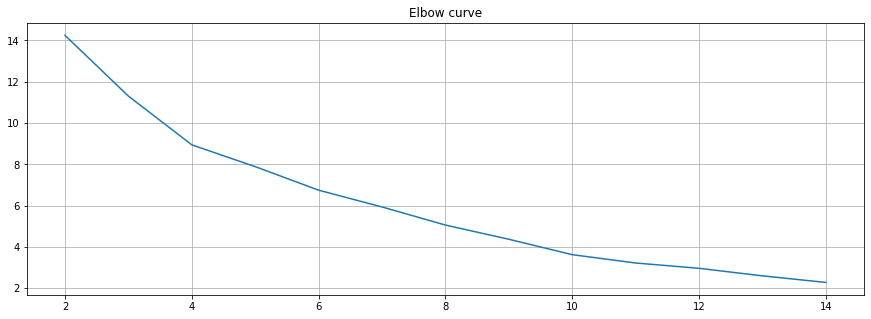

In [29]:
sse = []
for k in range(2, 15):
    k_means = KMeans(n_clusters=k)
    k_means.fit(data)
    sse.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 15), sse)
plt.grid(True)
plt.title('Elbow curve')

In [30]:
sse

[14.248313663911546,
 11.305469893398076,
 8.943203133140678,
 7.886686761589413,
 6.746428711175801,
 5.933093612577498,
 5.055973893747515,
 4.367789947568551,
 3.6214749698112385,
 3.2176488528578817,
 2.9599986194582204,
 2.5949261491314184,
 2.275602580913731]

#####Number of clusters =6

In [ ]:
# kmeans = KMeans(n_clusters = 6).fit(data)
# centroids = kmeans.cluster_centers_
# plt.scatter(data[:,0],data[:,1], c = kmeans.labels_, cmap ="rainbow")
# plt.show() -------->VISUALIZATION NOT NEEDED

In [31]:
print(returns.idxmax())
print(returns.idxmin())


Returns_mean           COP
Price                 CHTR
Daily_volatility       CZR
Cumulative_returns     COP
rolling_rets_1         COP
Volume_std            AMZN
Volume                AMZN
Volume_mean           BF-B
EMA_20                CHTR
EMA_60                CHTR
RSI_14                ABBV
dtype: object
Returns_mean          PYPL
Price                  CNP
Daily_volatility        PG
Cumulative_returns     ROL
rolling_rets_1        PYPL
Volume_std              RE
Volume                  RE
Volume_mean            XOM
EMA_20                 CNP
EMA_60                 CNP
RSI_14                PYPL
dtype: object


In [32]:
#drop the relevant stock from our data

# returns.drop(['COP','XOM'],inplace=True)

# print(returns)
#recreate data to feed into the algorithm

# data = np.asarray([np.asarray(returns['Returns_mean']),np.asarray(returns['Price']),np.asarray(returns['Daily_volatility']),np.asarray(returns['Cumulative_returns']),np.asarray(returns['rolling_rets_1']),np.asarray(returns['Volume'])]).T
# data
kmeans = KMeans(n_clusters =6 ).fit(data)
centroids = kmeans.cluster_centers_
# plt.scatter(data[:,0],data[:,1], c = kmeans.labels_, cmap ="rainbow")
# plt.show()


In [33]:
cluster_labels = np.asarray([np.asarray(returns.index),kmeans.labels_]).T
cluster_labels=pd.DataFrame(cluster_labels)
# print(cluster_labels)
cluster_labels.columns=['ID','Cluster']
cluster_labels.sort_values(by=['Cluster'])

,ID,Cluster
0,ABBV,0
32,KR,0
25,DXC,0
24,DRE,0
21,CZR,0
18,CNP,0
17,CNC,0
15,CDW,0
30,HIG,0
35,PRU,0


In [34]:
kmeans.inertia_

6.891027358953414

In [35]:
print(returns.idxmax())
print(returns.idxmin())

Returns_mean           COP
Price                 CHTR
Daily_volatility       CZR
Cumulative_returns     COP
rolling_rets_1         COP
Volume_std            AMZN
Volume                AMZN
Volume_mean           BF-B
EMA_20                CHTR
EMA_60                CHTR
RSI_14                ABBV
dtype: object
Returns_mean          PYPL
Price                  CNP
Daily_volatility        PG
Cumulative_returns     ROL
rolling_rets_1        PYPL
Volume_std              RE
Volume                  RE
Volume_mean            XOM
EMA_20                 CNP
EMA_60                 CNP
RSI_14                PYPL
dtype: object


#####PCA analysis 
***

In [36]:
returns

,Returns_mean,Price,Daily_volatility,Cumulative_returns,rolling_rets_1,Volume_std,Volume,Volume_mean,EMA_20,EMA_60,RSI_14
ABBV,0.666041,0.138791,0.087333,0.322568,0.666572,0.127572,0.097057,0.110935,0.138414,0.135802,1.000000
AEP,0.511724,0.090884,0.014380,0.200148,0.538542,0.035349,0.038087,0.058561,0.090202,0.089506,0.583333
AIZ,0.577419,0.199068,0.135815,0.340419,0.575522,0.002921,0.002003,0.069703,0.199067,0.197531,0.666667
ALLE,0.353566,0.158321,0.222797,0.262858,0.407811,0.005262,0.006268,0.085157,0.158631,0.158951,0.333333
AMAT,0.693912,0.166687,0.835432,0.791104,0.597943,0.105797,0.114335,0.028737,0.166407,0.166667,0.583333
AMP,0.684113,0.368993,0.353332,0.656215,0.643780,0.006328,0.004961,0.068487,0.368585,0.367284,0.833333
AMZN,0.397681,0.218455,0.402262,0.141206,0.387914,1.000000,1.000000,0.021264,0.217729,0.217593,0.333333
AVB,0.676499,0.287803,0.095685,0.638532,0.677634,0.006012,0.006298,0.067013,0.287714,0.287037,1.000000
AVY,0.469719,0.267233,0.288861,0.516030,0.466569,0.003016,0.003425,0.096375,0.267496,0.270062,0.500000
AXP,0.680322,0.209811,0.416651,0.592434,0.667343,0.052867,0.049937,0.068003,0.209953,0.208333,0.750000


In [37]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
#reduce data
reduced_data= PCA(n_components=2).fit_transform(returns)
#create kmeans model 
kmeans=KMeans(n_clusters=6,max_iter=1000)
#make pipeline 
pipeline=kmeans.fit(reduced_data)
# pipeline.fit(returns)
labels=pipeline.predict(reduced_data)



In [38]:
print(kmeans.inertia_)
df = pd.DataFrame({'ID':returns.index,'Cluster': labels})
print(df.sort_values('Cluster'))

2.070454641750857
      ID  Cluster
41   URI        0
40   UNH        0
37    RE        0
20  CTAS        0
23   DPZ        0
39  ROST        1
38   ROL        1
6   AMZN        1
36  PYPL        1
11  BF-B        1
27   FTV        1
0   ABBV        2
24   DRE        2
35   PRU        2
30   HIG        2
32    KR        2
28  GOOG        2
19   COP        2
44   XOM        2
4   AMAT        2
15   CDW        2
5    AMP        2
7    AVB        2
9    AXP        2
17   CNC        3
1    AEP        3
2    AIZ        3
8    AVY        3
34   PPL        3
33    PG        3
18   CNP        3
31   JPM        3
29   GPC        3
12   BMY        3
25   DXC        3
14  CARR        3
21   CZR        3
13    BR        4
26  META        4
43  VRSK        4
3   ALLE        4
42     V        4
10   BDX        4
22    DG        4
16  CHTR        5


In [39]:
returns2=returns[['Returns_mean','Price','Daily_volatility','Cumulative_returns','rolling_rets_1','Volume']]

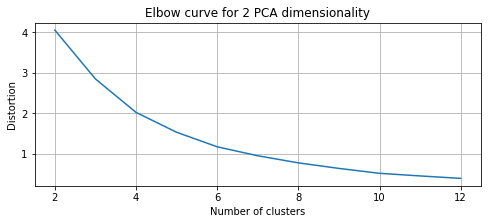

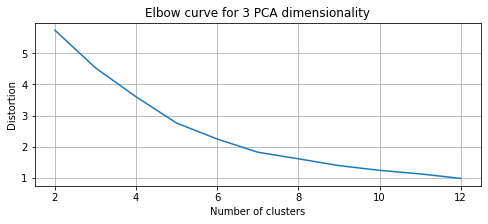

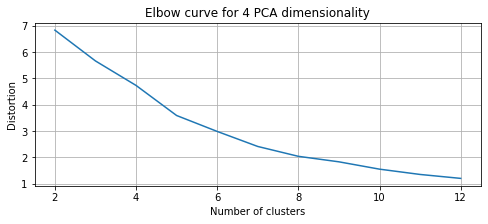

In [46]:
for i in range(2,5):
  sse=[]
  for k in range(2,13):
    reduced_data= PCA(n_components=i).fit_transform(returns2)
    #create kmeans model 
    kmeans=KMeans(n_clusters=k,max_iter=1000)
    #make pipeline 
    pipeline=kmeans.fit(reduced_data)
    # pipeline.fit(returns)
    labels=pipeline.predict(reduced_data)
    # print(pipeline.inertia_)
    sse.append(pipeline.inertia_)
  fig = plt.figure(figsize=(8, 3))
  plt.plot(range(2, 13), sse)
  plt.ylabel('Distortion')
  plt.xlabel('Number of clusters')
  plt.grid(True)
  plt.title('Elbow curve for %d PCA dimensionality' %(i))
  plt.savefig('Elbow curve'+ str(i) +'.png',dpi=400,bbox_inches='tight')

In [ ]:
# #alternate way 
# reduced_data=PCA(n_components=2).fit_transform(returns)
# h=0.01
# #plot decision boundary 
# x_min,x_max= reduced_data[:,0].min()-1,reduced_data[:,0].max() + 1
# y_min,y_max= reduced_data[:,1].min()-1,reduced_data[:,1].max() + 1
# xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
# z=kmeans.predict(np.c_[xx.ravel(),yy.ravel()])
# z=z.reshape(xx.shape)
# cmap=plt.cm.Paired
# plt.clf()
# plt.figure(figsize=(10,10))
# plt.imshow(z,interpolation='nearest',extent=(xx.min(),xx.max(),yy.min(),yy.max()),cmap=cmap,aspect='auto',origin='lower')
# # plt.plot(reduced_data[:,0],reduced_data[:,1],'k',markersize=5)

In [113]:
reduced_data= PCA(n_components=2).fit_transform(returns2)
#create kmeans model 
kmeans=KMeans(n_clusters=6,max_iter=15000)
#make pipeline 
pipeline=kmeans.fit(reduced_data)
# pipeline.fit(returns)
labels=pipeline.predict(reduced_data)

In [114]:
print(kmeans.inertia_)
df = pd.DataFrame({'ID':returns.index,'Cluster': labels})
print(df.sort_values('Cluster'))

1.1640235659203193
      ID  Cluster
0   ABBV        0
18   CNP        0
2    AIZ        0
40   UNH        0
17   CNC        0
14  CARR        0
7    AVB        0
8    AVY        0
37    RE        0
24   DRE        0
31   JPM        0
29   GPC        0
25   DXC        1
21   CZR        1
4   AMAT        1
41   URI        1
6   AMZN        2
39  ROST        2
16  CHTR        2
26  META        2
36  PYPL        2
44   XOM        3
19   COP        3
43  VRSK        4
42     V        4
1    AEP        4
3   ALLE        4
38   ROL        4
10   BDX        4
34   PPL        4
20  CTAS        4
33    PG        4
12   BMY        4
27   FTV        4
13    BR        4
23   DPZ        4
11  BF-B        4
22    DG        4
32    KR        5
30   HIG        5
35   PRU        5
28  GOOG        5
9    AXP        5
5    AMP        5
15   CDW        5


In [115]:
data5 = pd.DataFrame({'ID':returns.index,'x': reduced_data[:,0],'y':reduced_data[:,1]})
data5

,ID,x,y
0,ABBV,0.079025,-0.288246
1,AEP,-0.147664,-0.317051
2,AIZ,0.003086,-0.211262
3,ALLE,-0.211744,-0.052738
4,AMAT,0.535475,0.445830
5,AMP,0.319069,-0.004185
6,AMZN,-0.229932,0.309225
7,AVB,0.279522,-0.257145
8,AVY,0.041101,0.002913
9,AXP,0.326597,0.028688


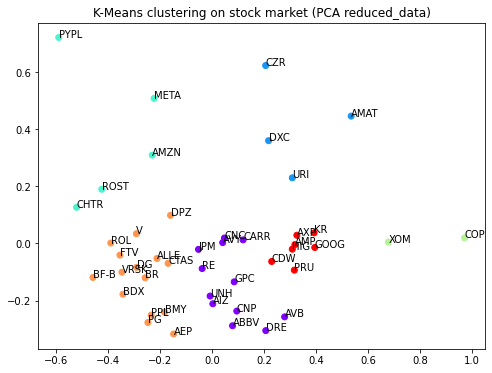

In [116]:
plt.figure(figsize=(8,6))
plt.scatter(reduced_data[:,0],reduced_data[:,1], c = kmeans.labels_, cmap ="rainbow")
for i, label in enumerate(data5['ID']):
    plt.annotate(label, (data5['x'][i], data5['y'][i]))
plt.title('K-Means clustering on stock market (PCA reduced_data)')
plt.savefig('groups.png',dpi=500)
plt.show() 

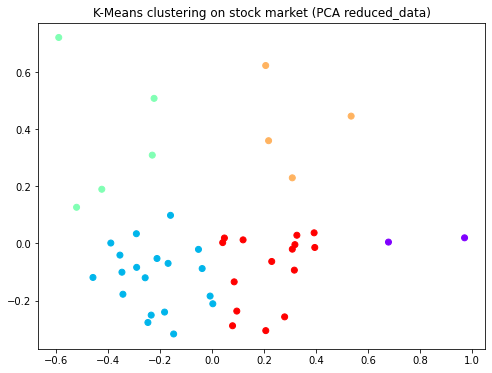

In [ ]:
# kmeans = KMeans(n_clusters = 6).fit(data)
# centroids = kmeans.cluster_centers_
plt.figure(figsize=(8,6))
plt.scatter(reduced_data[:,0],reduced_data[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.title('K-Means clustering on stock market (PCA reduced_data)')
plt.savefig('groups.png')
plt.show() 

In [117]:
returns3 = returns2.copy()
returns3.reset_index(inplace=True)
returns3.columns = ['ID','Returns_mean','Price','Daily_volatility','Cumulative_returns','rolling_rets_1','Volume']
# returns3 = returns3.merge(df, how='outer',on='ID')
len(returns3)
returns3.set_index('ID',inplace=True)
df.set_index('ID',inplace= True)

In [118]:
final_groups=pd.concat([returns3,df],axis=1)
final_groups

,Returns_mean,Price,Daily_volatility,Cumulative_returns,rolling_rets_1,Volume,Cluster
ID,,,,,,,
ABBV,0.666041,0.138791,0.087333,0.322568,0.666572,0.097057,0
AEP,0.511724,0.090884,0.014380,0.200148,0.538542,0.038087,4
AIZ,0.577419,0.199068,0.135815,0.340419,0.575522,0.002003,0
ALLE,0.353566,0.158321,0.222797,0.262858,0.407811,0.006268,4
AMAT,0.693912,0.166687,0.835432,0.791104,0.597943,0.114335,1
AMP,0.684113,0.368993,0.353332,0.656215,0.643780,0.004961,5
AMZN,0.397681,0.218455,0.402262,0.141206,0.387914,1.000000,2
AVB,0.676499,0.287803,0.095685,0.638532,0.677634,0.006298,0
AVY,0.469719,0.267233,0.288861,0.516030,0.466569,0.003425,0


In [119]:
final_groups.sort_values(by = 'Cluster')

,Returns_mean,Price,Daily_volatility,Cumulative_returns,rolling_rets_1,Volume,Cluster
ID,,,,,,,
ABBV,0.666041,0.138791,0.087333,0.322568,0.666572,0.097057,0
CNP,0.610982,0.000000,0.142901,0.363678,0.621324,0.069432,0
AIZ,0.577419,0.199068,0.135815,0.340419,0.575522,0.002003,0
UNH,0.609630,0.605630,0.116337,0.369525,0.641910,0.040052,0
CNC,0.573775,0.071587,0.412854,0.273683,0.600306,0.048900,0
CARR,0.519271,0.034855,0.349889,0.483157,0.511990,0.066741,0
AVB,0.676499,0.287803,0.095685,0.638532,0.677634,0.006298,0
AVY,0.469719,0.267233,0.288861,0.516030,0.466569,0.003425,0
RE,0.563155,0.360198,0.240237,0.314968,0.555547,0.000000,0


In [121]:
final_groups.to_excel('final_groups2.xlsx')

#####Features
***

In [122]:
for j in assets:
    df=stock[j] #all the days we need so we can fix the columns 
    # print('to df ftanei mexri ',stock[j].iloc[:-61].tail(1))
    # print(df)
    #τώρα θα προσθέσουμε τις καινούριες στήλες με τα features μας 
    df['(open2-open1)/open2']= (df['Open'].shift(2)-df['Open'].shift(1))/df['Open'].shift(2)
    df['(high2-high1)/high2']= (df['High'].shift(2)-df['High'].shift(1))/df['High'].shift(2)
    df['(low2-low1)/low2']= (df['Low'].shift(2)-df['Low'].shift(1))/df['Low'].shift(2)
    df['(Adj Close2-Adj Close1)/Adj Close2']=(df['Adj Close'].shift(2)-df['Adj Close'].shift(1))/df['Adj Close'].shift(2)
    df['av_3']=df['Adj Close'].shift(1).rolling(window=3).mean().pct_change()
    df['av_6']=df['Adj Close'].shift(1).rolling(window=6).mean().pct_change()
    df['av_10']=df['Adj Close'].shift(1).rolling(window=10).mean().pct_change()
    df['av_14']=df['Adj Close'].shift(1).rolling(window=14).mean().pct_change()
    # df['av_14']=df['Adj Close'].shift(1).rolling(window=14).mean().pct_change()
    df['high1-low1/high1']=(df['High'].shift(1)-df['Low'].shift(1))/df['High'].shift(1)
    df['close1-open1/close1']=(df['Close'].shift(1)-df['Open'].shift(1))/df['Close'].shift(1)
    df['RSI']= ta.RSI(np.array(df['Adj Close'].shift(1)),timeperiod=6)/100
    df['ADX'] = ta.ADX(df['High'].shift(1), df['Low'].shift(1), df['Close'].shift(1), timeperiod=6)/100
    df['RSI_14']= ta.RSI(np.array(df['Adj Close'].shift(1)),timeperiod=14)/100
    df['ADX_14'] = ta.ADX(df['High'].shift(1), df['Low'].shift(1), df['Close'].shift(1), timeperiod=14)/100
    df['TRIX_14'] =ta.TRIX(df['Adj Close'].shift(1),timeperiod=14)
    df['TRIX_10'] =ta.TRIX(df['Adj Close'].shift(1),timeperiod=10)
    df['WILLR']= ta.WILLR(df['High'].shift(1), df['Low'].shift(1), df['Close'].shift(1),timeperiod=14)/100
    df['std_dev']=df['Adj Close'].rolling(window=10).std().shift(1)
    df['dist_from_mean_10'] = (df['Adj Close'].shift(1) - (df['Adj Close'].shift(1).rolling(window=10).mean()))
    df['dist_from_mean_6'] = df['Adj Close'].shift(1) - (df['Adj Close'].shift(1).rolling(window=6).mean())
    df['MACD']= ta.MACD(df['Adj Close'].shift(1),fastperiod=5,slowperiod=14, signalperiod=8)[0]
    df['PPO']= ta.PPO(df['Adj Close'].shift(1), fastperiod= 5,slowperiod=14,matype=0)
    df['CMO_14']= ta.CMO(df['Adj Close'].shift(1),timeperiod=14)
    df = df.iloc[1: , :]
    df['absolute rank']= jk[j].astype(int).shift(1)
    df['Rank']= rd3[j]
    df1=df.drop('Volume',axis=1,inplace=True)
    df1=df.dropna()
    
    stock[j]=df1.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

#####Logistic Regression after clustering
***
2 solver methods like before 

In [130]:
clusters = pd.DataFrame({'ID':final_groups.index,'Cluster': final_groups['Cluster'].values})
# clusters
clusters.to_excel('cluster_after_pca.xlsx')


,ID,Cluster
0,ABBV,0
1,AEP,4
2,AIZ,0
3,ALLE,4
4,AMAT,1
5,AMP,5
6,AMZN,2
7,AVB,0
8,AVY,0
9,AXP,5


In [124]:
from sklearn.linear_model import LogisticRegression

In [131]:

num_of_clusters = np.arange(6)
RPS1=pd.DataFrame()
RPS2=pd.DataFrame()
# print(num_of_clusters)
for cluster in num_of_clusters :
  model1=LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=500)
  model2= LogisticRegression(multi_class='multinomial', solver='newton-cg',max_iter=500)
  id= clusters.loc[clusters['Cluster']==cluster].ID.values     #after pca analysis
  # id= cluster_labels.loc[cluster_labels['Cluster']==cluster].ID.values #-----> from initial clustering
  # print(id)
  #---predictions---#
  prob1= predictions(model1,id,stock,29)
  prob2= predictions(model2,id,stock,29)
  #---prob1abilities---#
  prob1['date']=stock['ABBV'].iloc[-60:].index
  prob2['date']=stock['ABBV'].iloc[-60:].index
  prob1_final=pd.DataFrame.from_dict(prob1)
  prob1_final.set_index('date')
  prob2_final=pd.DataFrame.from_dict(prob2)
  prob2_final.set_index('date')
  temp1= RPS_data(prob1_final,rd)
  temp1= create_RPS(prob1_final,temp1,id)
  temp2= RPS_data(prob2_final,rd)
  temp2= create_RPS(prob2_final,temp2,id)
  
  RPS1 = pd.concat([RPS1,temp1],axis=1)
  RPS2 = pd.concat([RPS2,temp2],axis=1)

ABBV
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.018282             0.020479          0.021798   
2021-03-05             0.003369            -0.005693          0.004836   
2021-03-08             0.004601             0.007053          0.008385   
2021-03-09            -0.007924            -0.010936         -0.016623   
2021-03-10             0.003463            -0.004900         -0.006049   
...                         ...                  ...               ...   
2022-03-24             0.000250            -0.005490         -0.002152   
2022-03-25             0.004937             0.002792         -0.003094   
2022-03-28            -0.008353            -0.007777         -0.008687   
2022-03-29            -0.000374            -0.000309          0.004369   
2022-03-30            -0.014819            -0.007715         -0.011032   

            (Adj Close2-Adj Clos

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.14715886 0.29849558 0.14701139 0.14938948 0.25794469]
AIZ
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.007303            -0.022385         -0.009595   
2021-03-05            -0.013948            -0.001927         -0.006256   
2021-03-08            -0.002487            -0.017467         -0.012120   
2021-03-09            -0.027987            -0.029418         -0.027760   
2021-03-10            -0.021795            -0.016089         -0.019293   
...                         ...                  ...               ...   
2022-03-24             0.002785             0.008876          0.004530   
2022-03-25            -0.002513            -0.018357         -0.001461   
2022-03-28            -0.021449            -0.009614         -0.025467   
2022-03-29            -0.004800             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.11420681 0.23247151 0.13816951 0.43176734 0.08338484]
AVB
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.014989            -0.022978         -0.013252   
2021-03-05            -0.013649             0.008014          0.011956   
2021-03-08             0.012748             0.010717          0.006647   
2021-03-09            -0.000224            -0.028278         -0.012468   
2021-03-10            -0.027775            -0.007348         -0.027792   
...                         ...                  ...               ...   
2022-03-24             0.011178             0.014663          0.005008   
2022-03-25             0.010606            -0.000370         -0.000333   
2022-03-28            -0.016246            -0.016602         -0.012931   
2022-03-29            -0.013574            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.09285973 0.0653557  0.31225137 0.38806687 0.14146632]
AVY
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.001409            -0.007604         -0.011503   
2021-03-05            -0.002532             0.007602          0.046846   
2021-03-08             0.018075             0.004921         -0.001484   
2021-03-09            -0.015492            -0.044167         -0.048127   
2021-03-10            -0.030624            -0.005112         -0.030140   
...                         ...                  ...               ...   
2022-03-24             0.014976             0.024260          0.031154   
2022-03-25             0.022157             0.009957         -0.000304   
2022-03-28            -0.012414            -0.030588         -0.019689   
2022-03-29            -0.028691            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.13736181 0.16583014 0.24968327 0.21089235 0.23623242]
CARR
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.014706            -0.004222          0.001363   
2021-03-05            -0.002714             0.009793          0.042861   
2021-03-08             0.022463             0.004569          0.008842   
2021-03-09            -0.018549            -0.020248         -0.044604   
2021-03-10            -0.015221             0.002117         -0.022039   
...                         ...                  ...               ...   
2022-03-24             0.015339             0.013456          0.012038   
2022-03-25             0.003628             0.011842          0.009042   
2022-03-28             0.010709             0.006206          0.010645   
2022-03-29            -0.005412            -0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.27694014 0.12180562 0.115486   0.19785561 0.28791263]
CNP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.011681             0.003551          0.006663   
2021-03-05            -0.014389            -0.039206         -0.009288   
2021-03-08            -0.019250            -0.019108         -0.025051   
2021-03-09            -0.045726            -0.011539         -0.027431   
2021-03-10             0.013308            -0.000475          0.000485   
...                         ...                  ...               ...   
2022-03-24            -0.001017            -0.006075          0.001363   
2022-03-25            -0.003388            -0.001342         -0.008530   
2022-03-28            -0.007090            -0.019430         -0.007781   
2022-03-29            -0.018773             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.21404634 0.18666047 0.12820418 0.24676613 0.22432288]
JPM
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.007663            -0.021083         -0.006540   
2021-03-05            -0.009125             0.003871          0.014587   
2021-03-08            -0.003997             0.005765          0.004374   
2021-03-09             0.004895            -0.012835         -0.018788   
2021-03-10             0.006362             0.007783          0.006169   
...                         ...                  ...               ...   
2022-03-24             0.009067             0.016258          0.017782   
2022-03-25             0.004823             0.006215          0.000647   
2022-03-28            -0.005631            -0.017554         -0.012149   
2022-03-29             0.007726             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.18941841 0.22895112 0.11369723 0.10732368 0.36060957]
RE
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.009080            -0.001677          0.002907   
2021-03-05            -0.004082            -0.004164          0.007164   
2021-03-08            -0.005434            -0.010124         -0.008558   
2021-03-09            -0.023889            -0.022339         -0.029493   
2021-03-10            -0.003183             0.004528          0.007233   
...                         ...                  ...               ...   
2022-03-24            -0.013819             0.000136         -0.013901   
2022-03-25            -0.003459            -0.004473         -0.004158   
2022-03-28            -0.005665            -0.010087         -0.008213   
2022-03-29            -0.014355             0.00

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.05481235 0.22016921 0.24327819 0.30433936 0.17740088]
UNH
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.005015            -0.001451          0.003324   
2021-03-05            -0.002550            -0.007925          0.000331   
2021-03-08            -0.002573            -0.021858         -0.007064   
2021-03-09            -0.035758            -0.016394         -0.031580   
2021-03-10            -0.017031            -0.020480         -0.016609   
...                         ...                  ...               ...   
2022-03-24             0.013745             0.009358          0.006953   
2022-03-25            -0.005435            -0.017197         -0.005047   
2022-03-28            -0.018198            -0.001454         -0.010678   
2022-03-29            -0.000253            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.11976694 0.2315611  0.28411065 0.1791708  0.18539052]
ABBV
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.018282             0.020479          0.021798   
2021-03-05             0.003369            -0.005693          0.004836   
2021-03-08             0.004601             0.007053          0.008385   
2021-03-09            -0.007924            -0.010936         -0.016623   
2021-03-10             0.003463            -0.004900         -0.006049   
...                         ...                  ...               ...   
2022-03-24             0.000250            -0.005490         -0.002152   
2022-03-25             0.004937             0.002792         -0.003094   
2022-03-28            -0.008353            -0.007777         -0.008687   
2022-03-29            -0.000374            -0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 ABBV  \
59  [0.14715886290835556, 0.298495578990169, 0.147...   

                                                  AIZ  \
59  [0.11420680689050845, 0.23247150564102176, 0.1...   

                                                  AVB  \
59  [0.092859730095544, 0.06535570336837875, 0.312...   

                                                  AVY  \
59  [0.1373618143160445, 0.16583013912830222, 0.24...   

                                                 CARR  \
59  [0.12109847921868569, 0.1740781046273088, 0.26..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 ABBV  \
59  [0.14761502842844063, 0.2982638897674341, 0.14...   

                                                  AIZ  \
59  [0.11490167669398553, 0.23322472882625445, 0.1...   

                                                  AVB  \
59  [0.09223302611288883, 0.06565198575783951, 0.3...   

                                                  AVY  \
59  [0.13736171072814582, 0.16501196002373836, 0.2...   

                                                 CARR  \
59  [0.12124294722476513, 0.1741484407800797, 0.26..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMAT
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.029219             0.016898          0.018253   
2021-03-05             0.024856             0.028035          0.069244   
2021-03-08             0.032513             0.018457          0.013815   
2021-03-09            -0.010843             0.001924          0.001420   
2021-03-10             0.022518            -0.007273         -0.037062   
...                         ...                  ...               ...   
2022-03-24             0.002910             0.016310          0.019798   
2022-03-25             0.004491            -0.026277         -0.000991   
2022-03-28            -0.042253            -0.002452         -0.026422   
2022-03-29             0.025536             0.008922          0.008160   
2022-03-30            -0.036938            -0.030926         -0.038968   

            (Adj Close2-Adj Clos

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.12446305 0.20021941 0.09111445 0.19524921 0.38895388]
CZR
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.017195            -0.031634         -0.012215   
2021-03-05            -0.007980             0.021190          0.072832   
2021-03-08             0.043542             0.023314          0.033402   
2021-03-09            -0.034306            -0.039535         -0.111118   
2021-03-10            -0.026640            -0.004100         -0.000268   
...                         ...                  ...               ...   
2022-03-24            -0.005833             0.012376          0.022135   
2022-03-25             0.027988             0.009900          0.018850   
2022-03-28            -0.026589            -0.001772         -0.021466   
2022-03-29             0.019583             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.42298098 0.09036266 0.13024337 0.01580886 0.34060413]
DXC
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.003884            -0.014559         -0.003118   
2021-03-05            -0.017021            -0.015861          0.017094   
2021-03-08             0.001141            -0.015985         -0.007510   
2021-03-09            -0.049124            -0.049396         -0.077678   
2021-03-10            -0.029764            -0.004881         -0.016017   
...                         ...                  ...               ...   
2022-03-24            -0.002420             0.012481          0.030625   
2022-03-25             0.019010             0.001806         -0.007507   
2022-03-28            -0.013842            -0.014772         -0.018317   
2022-03-29            -0.011226             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.33231773 0.09520815 0.17591136 0.12867221 0.26789055]
URI
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.031015             0.004440         -0.002257   
2021-03-05             0.000238            -0.001321          0.035417   
2021-03-08             0.004855             0.003299          0.001769   
2021-03-09            -0.036811            -0.019993         -0.064777   
2021-03-10             0.004771             0.012754          0.023063   
...                         ...                  ...               ...   
2022-03-24            -0.014286            -0.008629         -0.007038   
2022-03-25            -0.003521             0.004402         -0.000170   
2022-03-28            -0.010554            -0.013683         -0.019201   
2022-03-29            -0.006750             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.36237312 0.19805333 0.07542006 0.22504679 0.1391067 ]
AMAT
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.029219             0.016898          0.018253   
2021-03-05             0.024856             0.028035          0.069244   
2021-03-08             0.032513             0.018457          0.013815   
2021-03-09            -0.010843             0.001924          0.001420   
2021-03-10             0.022518            -0.007273         -0.037062   
...                         ...                  ...               ...   
2022-03-24             0.002910             0.016310          0.019798   
2022-03-25             0.004491            -0.026277         -0.000991   
2022-03-28            -0.042253            -0.002452         -0.026422   
2022-03-29             0.025536             0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMAT  \
59  [0.12446305065537643, 0.20021940670737068, 0.0...   

                                                  CZR  \
59  [0.4229809778942721, 0.0903626600317275, 0.130...   

                                                  DXC  \
59  [0.33231772863415765, 0.09520815387318181, 0.1...   

                                                  URI  
59  [0.3623731188312884, 0.19805332853691174, 0.07...  
     ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  AMAT  0.124463  0.200219  0.091114  0.195249  0.388

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMAT  \
59  [0.12417483202729239, 0.19939276021980912, 0.0...   

                                                  CZR  \
59  [0.4224608682838713, 0.0915546064600336, 0.130...   

                                                  DXC  \
59  [0.3320316135346556, 0.0954015003238161, 0.175...   

                                                  URI  
59  [0.36256582128088005, 0.1986559905366198, 0.07...  
     ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  AMAT  0.124175  0.199393  0.090162  0.196477  0.389

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMZN
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.019816             0.017620          0.029840   
2021-03-05             0.022452             0.015976          0.016551   
2021-03-08             0.002324             0.016065          0.021875   
2021-03-09            -0.003328            -0.018475         -0.024405   
2021-03-10            -0.000992            -0.008605         -0.018243   
...                         ...                  ...               ...   
2022-03-24            -0.011739            -0.001222         -0.006110   
2022-03-25            -0.000272             0.013533          0.016209   
2022-03-28            -0.001530            -0.007616         -0.013746   
2022-03-29            -0.005945            -0.022187         -0.016333   
2022-03-30            -0.032787            -0.010613         -0.018002   

            (Adj Close2-Adj Clos

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.016709             0.017262          0.018568   
2021-03-05             0.021258            -0.008049          0.003151   
2021-03-08            -0.025042            -0.017845         -0.019481   
2021-03-09            -0.012606            -0.000794         -0.003133   
2021-03-10             0.002236             0.015630          0.000965   
...                         ...                  ...               ...   
2022-03-24            -0.006744             0.001767          0.011855   
2022-03-25             0.014897             0.007967          0.003111   
2022-03-28             0.008234             0.013070          0.023262   
2022-03-29             0.004678            -0.002234         -0.017885   
2022-03-30            -0.012467            -0.015744         -0.018202   

            (Adj Close2-Adj Close1)/A

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.27206675 0.42253674 0.06716909 0.05734501 0.18088241]
PYPL
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.039643             0.035459          0.058235   
2021-03-05             0.050034             0.048046          0.082843   
2021-03-08             0.034318             0.043375          0.039523   
2021-03-09             0.016946             0.009920         -0.011475   
2021-03-10            -0.008285            -0.012887         -0.046045   
...                         ...                  ...               ...   
2022-03-24            -0.007676             0.016674          0.004884   
2022-03-25            -0.002510             0.009969          0.006749   
2022-03-28            -0.001900             0.000000          0.010854   
2022-03-29             0.017580            -0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.1154214  0.20879607 0.0413445  0.27663666 0.35780137]
ROST
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.054726             0.037107          0.047521   
2021-03-05             0.028684             0.035791          0.021021   
2021-03-08            -0.027635            -0.014331         -0.009676   
2021-03-09            -0.007646            -0.061957         -0.035232   
2021-03-10            -0.065062            -0.050161         -0.068330   
...                         ...                  ...               ...   
2022-03-24             0.009902             0.024738          0.023710   
2022-03-25             0.007034             0.003843         -0.002361   
2022-03-28            -0.010293            -0.009039          0.005833   
2022-03-29             0.010408            -0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.3402882  0.20380199 0.05775473 0.19439393 0.20376115]
AMZN
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.019816             0.017620          0.029840   
2021-03-05             0.022452             0.015976          0.016551   
2021-03-08             0.002324             0.016065          0.021875   
2021-03-09            -0.003328            -0.018475         -0.024405   
2021-03-10            -0.000992            -0.008605         -0.018243   
...                         ...                  ...               ...   
2022-03-24            -0.011739            -0.001222         -0.006110   
2022-03-25            -0.000272             0.013533          0.016209   
2022-03-28            -0.001530            -0.007616         -0.013746   
2022-03-29            -0.005945            -0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMZN  \
59  [0.0711556622369691, 0.19614979491360784, 0.24...   

                                                 CHTR  \
59  [0.28672820598834237, 0.16826940780244637, 0.1...   

                                                 META  \
59  [0.2720667485570805, 0.4225367398810877, 0.067...   

                                                 PYPL  \
59  [0.11542139674198625, 0.20879606856000943, 0.0...   

                                                 ROST  
59  [0.3402881978458293, 0.20380198983673908, 0.05...

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMZN  \
59  [0.07133646297108688, 0.19672137445286075, 0.2...   

                                                 CHTR  \
59  [0.2887136452543275, 0.16699713784363854, 0.17...   

                                                 META  \
59  [0.27334913811730355, 0.4234540517006065, 0.06...   

                                                 PYPL  \
59  [0.11556892594772729, 0.2115465170184093, 0.04...   

                                                 ROST  
59  [0.34024725346400203, 0.20375346155878332, 0.0...

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


COP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.002857            -0.027585         -0.005934   
2021-03-05            -0.024687            -0.040723         -0.021503   
2021-03-08            -0.074870            -0.043867         -0.063897   
2021-03-09            -0.013276            -0.007564         -0.010156   
2021-03-10             0.002382             0.005672          0.004160   
...                         ...                  ...               ...   
2022-03-24            -0.005357            -0.020900         -0.028608   
2022-03-25            -0.016954            -0.007903         -0.005427   
2022-03-28             0.007621            -0.015777         -0.000675   
2022-03-29            -0.008544             0.022135          0.007802   
2022-03-30             0.048258             0.039947          0.050189   

            (Adj Close2-Adj Close

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.02408904 0.29763604 0.33075807 0.06750536 0.28001148]
XOM
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.004060            -0.017556          0.002499   
2021-03-05            -0.012407            -0.026052         -0.021832   
2021-03-08            -0.047444            -0.026568         -0.035201   
2021-03-09            -0.029250            -0.009173         -0.012011   
2021-03-10             0.015752             0.003571          0.005851   
...                         ...                  ...               ...   
2022-03-24            -0.020948            -0.025182         -0.027974   
2022-03-25            -0.001440            -0.004509          0.003612   
2022-03-28             0.006470            -0.009923         -0.000483   
2022-03-29            -0.003015             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.2056127  0.25237914 0.05448383 0.11562247 0.37190186]
COP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.002857            -0.027585         -0.005934   
2021-03-05            -0.024687            -0.040723         -0.021503   
2021-03-08            -0.074870            -0.043867         -0.063897   
2021-03-09            -0.013276            -0.007564         -0.010156   
2021-03-10             0.002382             0.005672          0.004160   
...                         ...                  ...               ...   
2022-03-24            -0.005357            -0.020900         -0.028608   
2022-03-25            -0.016954            -0.007903         -0.005427   
2022-03-28             0.007621            -0.015777         -0.000675   
2022-03-29            -0.008544             0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  COP  \
59  [0.024089041582657043, 0.2976360428219824, 0.3...   

                                                  XOM  
59  [0.20561270271481216, 0.2523791379491497, 0.05...  
    ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  COP  0.024089  0.297636  0.330758  0.067505  0.280011
1  XOM  0.205613  0.252379  0.054484  0.115622  0.371902


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  COP  \
59  [0.024225161375306458, 0.2964876212944157, 0.3...   

                                                  XOM  
59  [0.20519453118571987, 0.2529608120126036, 0.05...  
    ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  COP  0.024225  0.296488  0.330807  0.067360  0.281120
1  XOM  0.205195  0.252961  0.054124  0.115409  0.372312


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AEP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.008197             0.008944          0.012255   
2021-03-05            -0.001312            -0.021711         -0.016409   
2021-03-08            -0.015328            -0.014977         -0.013913   
2021-03-09            -0.017161            -0.021062         -0.018770   
2021-03-10            -0.025878            -0.002717         -0.020457   
...                         ...                  ...               ...   
2022-03-24            -0.004961            -0.009205         -0.007954   
2022-03-25            -0.011450            -0.007359         -0.006524   
2022-03-28            -0.000623            -0.002058         -0.007213   
2022-03-29            -0.004463            -0.002362          0.003944   
2022-03-30            -0.007026            -0.012190         -0.014379   

            (Adj Close2-Adj Close

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.1010265  0.16579539 0.18605316 0.32222335 0.2249016 ]
BDX
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.012666             0.010481          0.008793   
2021-03-05             0.008894             0.002658          0.011483   
2021-03-08            -0.000083            -0.015294         -0.010442   
2021-03-09            -0.016416            -0.008198         -0.012741   
2021-03-10            -0.005248             0.006209          0.005368   
...                         ...                  ...               ...   
2022-03-24             0.011642             0.008927          0.009528   
2022-03-25             0.011817             0.009683         -0.003948   
2022-03-28            -0.007731            -0.007314         -0.003092   
2022-03-29            -0.005026            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.22641747 0.12291136 0.20782024 0.26367811 0.17917283]
CTAS
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.003466             0.003805          0.017542   
2021-03-05             0.014527             0.022337          0.043596   
2021-03-08             0.020050            -0.010506         -0.006659   
2021-03-09            -0.033112            -0.008786         -0.044694   
2021-03-10            -0.009551            -0.015300         -0.007308   
...                         ...                  ...               ...   
2022-03-24            -0.001422            -0.022466         -0.000844   
2022-03-25            -0.026619            -0.014360         -0.018672   
2022-03-28            -0.019854            -0.008138         -0.020285   
2022-03-29             0.002421            -0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[8.57658834e-01 3.81530786e-02 9.07144141e-02 3.36573317e-04
 1.31371004e-02]
DG
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.040306             0.033841          0.018570   
2021-03-05             0.017091             0.022995          0.034015   
2021-03-08             0.018979             0.018281          0.012964   
2021-03-09            -0.006374            -0.029940         -0.024606   
2021-03-10            -0.020946            -0.013912         -0.022503   
...                         ...                  ...               ...   
2022-03-24             0.017696             0.016751          0.022979   
2022-03-25             0.014332             0.013806          0.004049   
2022-03-28             0.001936             0.002468         -0.001233   
2022-03-29             0.00

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.09288594 0.06103217 0.24868268 0.56533686 0.03206236]
DPZ
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.013282             0.013986          0.025400   
2021-03-05             0.023608             0.010857          0.016913   
2021-03-08             0.008230             0.022218          0.021276   
2021-03-09             0.000575            -0.015722         -0.018517   
2021-03-10            -0.028364            -0.053506         -0.035163   
...                         ...                  ...               ...   
2022-03-24             0.010727             0.009785          0.010324   
2022-03-25             0.004186             0.007065          0.009176   
2022-03-28             0.002355             0.000405          0.000854   
2022-03-29            -0.009163            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.11506304 0.38906949 0.15857019 0.12834786 0.20894943]
FTV
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.001031            -0.003519         -0.006288   
2021-03-05             0.003385             0.005406          0.029842   
2021-03-08             0.009746             0.011899          0.010203   
2021-03-09            -0.008351            -0.040737         -0.030462   
2021-03-10            -0.023810            -0.001143         -0.024634   
...                         ...                  ...               ...   
2022-03-24             0.011688             0.018287          0.018084   
2022-03-25             0.005421            -0.004085         -0.000664   
2022-03-28            -0.015359            -0.005858         -0.013928   
2022-03-29             0.000976            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.11448978 0.08725752 0.37935018 0.26964896 0.14925356]
PPL
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.005578            -0.010249         -0.003736   
2021-03-05            -0.019231            -0.017029         -0.018236   
2021-03-08            -0.014877            -0.010331         -0.012427   
2021-03-09            -0.015374            -0.019746         -0.020578   
2021-03-10             0.025704             0.035270          0.037496   
...                         ...                  ...               ...   
2022-03-24             0.003333             0.002214         -0.001504   
2022-03-25            -0.002973            -0.010725         -0.009388   
2022-03-28            -0.009633            -0.012806         -0.013765   
2022-03-29            -0.011009            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.011550             0.005864          0.003775   
2021-03-05             0.005570             0.009089          0.023348   
2021-03-08             0.009924            -0.024236         -0.007510   
2021-03-09            -0.042799            -0.028763         -0.046773   
2021-03-10            -0.038861            -0.022309         -0.032400   
...                         ...                  ...               ...   
2022-03-24             0.003555             0.011113          0.013011   
2022-03-25             0.005090             0.006069          0.000000   
2022-03-28             0.001004             0.002671          0.004507   
2022-03-29             0.004068            -0.014398         -0.008423   
2022-03-30            -0.023645            -0.017211         -0.027133   

            (Adj Close2-Adj Close1)/A

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AEP  \
59  [0.16316169646531592, 0.17590270705563585, 0.3...   

                                                 ALLE  \
59  [0.10102649879073701, 0.16579538786842976, 0.1...   

                                                  BDX  \
59  [0.16173387299916508, 0.15977790517571303, 0.2...   

                                                 BF-B  \
59  [0.2801473305053618, 0.23860088283420605, 0.14...   

                                                  BMY  \
59  [0.260594167827013, 0.23590000686531098, 0.221..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AEP  \
59  [0.16367288549325204, 0.17599416731519293, 0.3...   

                                                 ALLE  \
59  [0.10083480538420198, 0.16569743889659985, 0.1...   

                                                  BDX  \
59  [0.16173337017779355, 0.16000115361616438, 0.2...   

                                                 BF-B  \
59  [0.2801603143695485, 0.2387876722991912, 0.149...   

                                                  BMY  \
59  [0.2607047514941898, 0.23606111451845788, 0.22..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.006659             0.003536          0.010674   
2021-03-05             0.021345             0.017480          0.044767   
2021-03-08             0.002929             0.004325         -0.002437   
2021-03-09            -0.016903            -0.030004         -0.044787   
2021-03-10             0.005956             0.012870          0.009755   
...                         ...                  ...               ...   
2022-03-24            -0.007662            -0.003180         -0.002886   
2022-03-25             0.001835            -0.008377          0.000827   
2022-03-28            -0.025678            -0.014112         -0.028930   
2022-03-29            -0.007748             0.003827          0.009329   
2022-03-30            -0.007942            -0.011176         -0.007923   

            (Adj Close2-Adj Close

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.10252993 0.12121015 0.27685653 0.28058917 0.21881422]
AXP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.012731            -0.028961         -0.013905   
2021-03-05            -0.015357             0.000971          0.000357   
2021-03-08            -0.017657            -0.026716         -0.015220   
2021-03-09            -0.018111            -0.023655         -0.032658   
2021-03-10            -0.008827             0.015714          0.017789   
...                         ...                  ...               ...   
2022-03-24             0.008766             0.024338          0.025676   
2022-03-25             0.011757             0.001318         -0.002808   
2022-03-28            -0.020363            -0.009980         -0.017771   
2022-03-29             0.002416             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.28780922 0.26572629 0.06458122 0.33433442 0.04754884]
CDW
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.021937             0.023693          0.015685   
2021-03-05             0.010288             0.007771          0.035432   
2021-03-08             0.006844             0.003402         -0.002082   
2021-03-09            -0.001625            -0.012560         -0.024729   
2021-03-10            -0.011683            -0.000763         -0.008240   
...                         ...                  ...               ...   
2022-03-24             0.011239             0.010871          0.016900   
2022-03-25             0.015250             0.010430          0.001834   
2022-03-28            -0.010800            -0.003853          0.000689   
2022-03-29             0.008028            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.11825056 0.29483805 0.10074534 0.34321754 0.14294851]
KR
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.005506            -0.002105          0.003406   
2021-03-05            -0.045832            -0.039304         -0.029512   
2021-03-08            -0.011765            -0.019919         -0.029873   
2021-03-09            -0.006977             0.002264         -0.011134   
2021-03-10            -0.003176             0.002270          0.002608   
...                         ...                  ...               ...   
2022-03-24            -0.013214            -0.007042         -0.018864   
2022-03-25             0.002467            -0.011888         -0.004451   
2022-03-28            -0.000353             0.008811         -0.001241   
2022-03-29            -0.006535            -0.00

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.06720063 0.41376907 0.08503047 0.16861744 0.26538239]
AMP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.006659             0.003536          0.010674   
2021-03-05             0.021345             0.017480          0.044767   
2021-03-08             0.002929             0.004325         -0.002437   
2021-03-09            -0.016903            -0.030004         -0.044787   
2021-03-10             0.005956             0.012870          0.009755   
...                         ...                  ...               ...   
2022-03-24            -0.007662            -0.003180         -0.002886   
2022-03-25             0.001835            -0.008377          0.000827   
2022-03-28            -0.025678            -0.014112         -0.028930   
2022-03-29            -0.007748             0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AMP  \
59  [0.10252992690726359, 0.12121015203885577, 0.2...   

                                                  AXP  \
59  [0.28780922158637356, 0.26572628561348016, 0.0...   

                                                  CDW  \
59  [0.18232172814388095, 0.09088831243598924, 0.1...   

                                                 GOOG  \
59  [0.2542093405367784, 0.12188837620980625, 0.40...   

                                                  HIG  \
59  [0.11825055926456772, 0.2948380474573551, 0.10..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AMP  \
59  [0.105613775468719, 0.11946425526916321, 0.273...   

                                                  AXP  \
59  [0.2873051432662532, 0.26634371603521556, 0.06...   

                                                  CDW  \
59  [0.18363275819073838, 0.09040824067610231, 0.1...   

                                                 GOOG  \
59  [0.2530860835746354, 0.12279834454171025, 0.40...   

                                                  HIG  \
59  [0.11825390203994945, 0.2947225582438262, 0.10..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [132]:
print('solver 1 results :', RPS1.mean(axis=1).mean())
print('solver  results :' , RPS2.mean(axis=1).mean())

solver 1 results : 0.17112453481032017
solver  results : 0.17114935263737632


In [133]:
from sklearn.linear_model import LogisticRegression
num_of_clusters = np.arange(6)
RPS1=pd.DataFrame()
RPS2=pd.DataFrame()
# print(num_of_clusters)
for cluster in num_of_clusters :
  model1=LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=500)
  model2= LogisticRegression(multi_class='multinomial', solver='newton-cg',max_iter=500)
  id= clusters.loc[clusters['Cluster']==cluster].ID.values     #after pca analysis
  # id= cluster_labels.loc[cluster_labels['Cluster']==cluster].ID.values #-----> from initial clustering
  # print(id)
  #---predictions---#
  prob1= predictions(model1,id,stock,29)
  prob2= predictions(model2,id,stock,29)
  #---prob1abilities---#
  prob1['date']=stock['ABBV'].iloc[-60:].index
  prob2['date']=stock['ABBV'].iloc[-60:].index
  prob1_final=pd.DataFrame.from_dict(prob1)
  prob1_final.set_index('date')
  prob2_final=pd.DataFrame.from_dict(prob2)
  prob2_final.set_index('date')
  temp1= RPS_data(prob1_final,rd)
  temp1= create_RPS(prob1_final,temp1,id)
  temp2= RPS_data(prob2_final,rd)
  temp2= create_RPS(prob2_final,temp2,id)

  RPS1 = pd.concat([RPS1,temp1],axis=1)
  RPS2 = pd.concat([RPS2,temp2],axis=1)
  # print(RPS1)
  

RPS1
RPS2

ABBV
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.018282             0.020479          0.021798   
2021-03-05             0.003369            -0.005693          0.004836   
2021-03-08             0.004601             0.007053          0.008385   
2021-03-09            -0.007924            -0.010936         -0.016623   
2021-03-10             0.003463            -0.004900         -0.006049   
...                         ...                  ...               ...   
2022-03-24             0.000250            -0.005490         -0.002152   
2022-03-25             0.004937             0.002792         -0.003094   
2022-03-28            -0.008353            -0.007777         -0.008687   
2022-03-29            -0.000374            -0.000309          0.004369   
2022-03-30            -0.014819            -0.007715         -0.011032   

            (Adj Close2-Adj Clos

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.14715886 0.29849558 0.14701139 0.14938948 0.25794469]
AIZ
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.007303            -0.022385         -0.009595   
2021-03-05            -0.013948            -0.001927         -0.006256   
2021-03-08            -0.002487            -0.017467         -0.012120   
2021-03-09            -0.027987            -0.029418         -0.027760   
2021-03-10            -0.021795            -0.016089         -0.019293   
...                         ...                  ...               ...   
2022-03-24             0.002785             0.008876          0.004530   
2022-03-25            -0.002513            -0.018357         -0.001461   
2022-03-28            -0.021449            -0.009614         -0.025467   
2022-03-29            -0.004800             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.11420681 0.23247151 0.13816951 0.43176734 0.08338484]
AVB
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.014989            -0.022978         -0.013252   
2021-03-05            -0.013649             0.008014          0.011956   
2021-03-08             0.012748             0.010717          0.006647   
2021-03-09            -0.000224            -0.028278         -0.012468   
2021-03-10            -0.027775            -0.007348         -0.027792   
...                         ...                  ...               ...   
2022-03-24             0.011178             0.014663          0.005008   
2022-03-25             0.010606            -0.000370         -0.000333   
2022-03-28            -0.016246            -0.016602         -0.012931   
2022-03-29            -0.013574            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.09285973 0.0653557  0.31225137 0.38806687 0.14146632]
AVY
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.001409            -0.007604         -0.011503   
2021-03-05            -0.002532             0.007602          0.046846   
2021-03-08             0.018075             0.004921         -0.001484   
2021-03-09            -0.015492            -0.044167         -0.048127   
2021-03-10            -0.030624            -0.005112         -0.030140   
...                         ...                  ...               ...   
2022-03-24             0.014976             0.024260          0.031154   
2022-03-25             0.022157             0.009957         -0.000304   
2022-03-28            -0.012414            -0.030588         -0.019689   
2022-03-29            -0.028691            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.13736181 0.16583014 0.24968327 0.21089235 0.23623242]
CARR
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.014706            -0.004222          0.001363   
2021-03-05            -0.002714             0.009793          0.042861   
2021-03-08             0.022463             0.004569          0.008842   
2021-03-09            -0.018549            -0.020248         -0.044604   
2021-03-10            -0.015221             0.002117         -0.022039   
...                         ...                  ...               ...   
2022-03-24             0.015339             0.013456          0.012038   
2022-03-25             0.003628             0.011842          0.009042   
2022-03-28             0.010709             0.006206          0.010645   
2022-03-29            -0.005412            -0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.27694014 0.12180562 0.115486   0.19785561 0.28791263]
CNP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.011681             0.003551          0.006663   
2021-03-05            -0.014389            -0.039206         -0.009288   
2021-03-08            -0.019250            -0.019108         -0.025051   
2021-03-09            -0.045726            -0.011539         -0.027431   
2021-03-10             0.013308            -0.000475          0.000485   
...                         ...                  ...               ...   
2022-03-24            -0.001017            -0.006075          0.001363   
2022-03-25            -0.003388            -0.001342         -0.008530   
2022-03-28            -0.007090            -0.019430         -0.007781   
2022-03-29            -0.018773             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.21404634 0.18666047 0.12820418 0.24676613 0.22432288]
JPM
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.007663            -0.021083         -0.006540   
2021-03-05            -0.009125             0.003871          0.014587   
2021-03-08            -0.003997             0.005765          0.004374   
2021-03-09             0.004895            -0.012835         -0.018788   
2021-03-10             0.006362             0.007783          0.006169   
...                         ...                  ...               ...   
2022-03-24             0.009067             0.016258          0.017782   
2022-03-25             0.004823             0.006215          0.000647   
2022-03-28            -0.005631            -0.017554         -0.012149   
2022-03-29             0.007726             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.18941841 0.22895112 0.11369723 0.10732368 0.36060957]
RE
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.009080            -0.001677          0.002907   
2021-03-05            -0.004082            -0.004164          0.007164   
2021-03-08            -0.005434            -0.010124         -0.008558   
2021-03-09            -0.023889            -0.022339         -0.029493   
2021-03-10            -0.003183             0.004528          0.007233   
...                         ...                  ...               ...   
2022-03-24            -0.013819             0.000136         -0.013901   
2022-03-25            -0.003459            -0.004473         -0.004158   
2022-03-28            -0.005665            -0.010087         -0.008213   
2022-03-29            -0.014355             0.00

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.005015            -0.001451          0.003324   
2021-03-05            -0.002550            -0.007925          0.000331   
2021-03-08            -0.002573            -0.021858         -0.007064   
2021-03-09            -0.035758            -0.016394         -0.031580   
2021-03-10            -0.017031            -0.020480         -0.016609   
...                         ...                  ...               ...   
2022-03-24             0.013745             0.009358          0.006953   
2022-03-25            -0.005435            -0.017197         -0.005047   
2022-03-28            -0.018198            -0.001454         -0.010678   
2022-03-29            -0.000253            -0.001181          0.000844   
2022-03-30            -0.005405            -0.004738          0.002968   

            (Adj Close2-Adj Close1)/A

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.11976694 0.2315611  0.28411065 0.1791708  0.18539052]
ABBV
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.018282             0.020479          0.021798   
2021-03-05             0.003369            -0.005693          0.004836   
2021-03-08             0.004601             0.007053          0.008385   
2021-03-09            -0.007924            -0.010936         -0.016623   
2021-03-10             0.003463            -0.004900         -0.006049   
...                         ...                  ...               ...   
2022-03-24             0.000250            -0.005490         -0.002152   
2022-03-25             0.004937             0.002792         -0.003094   
2022-03-28            -0.008353            -0.007777         -0.008687   
2022-03-29            -0.000374            -0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 ABBV  \
59  [0.14715886290835556, 0.298495578990169, 0.147...   

                                                  AIZ  \
59  [0.11420680689050845, 0.23247150564102176, 0.1...   

                                                  AVB  \
59  [0.092859730095544, 0.06535570336837875, 0.312...   

                                                  AVY  \
59  [0.1373618143160445, 0.16583013912830222, 0.24...   

                                                 CARR  \
59  [0.12109847921868569, 0.1740781046273088, 0.26..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 ABBV  \
59  [0.14761502842844063, 0.2982638897674341, 0.14...   

                                                  AIZ  \
59  [0.11490167669398553, 0.23322472882625445, 0.1...   

                                                  AVB  \
59  [0.09223302611288883, 0.06565198575783951, 0.3...   

                                                  AVY  \
59  [0.13736171072814582, 0.16501196002373836, 0.2...   

                                                 CARR  \
59  [0.12124294722476513, 0.1741484407800797, 0.26..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMAT
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.029219             0.016898          0.018253   
2021-03-05             0.024856             0.028035          0.069244   
2021-03-08             0.032513             0.018457          0.013815   
2021-03-09            -0.010843             0.001924          0.001420   
2021-03-10             0.022518            -0.007273         -0.037062   
...                         ...                  ...               ...   
2022-03-24             0.002910             0.016310          0.019798   
2022-03-25             0.004491            -0.026277         -0.000991   
2022-03-28            -0.042253            -0.002452         -0.026422   
2022-03-29             0.025536             0.008922          0.008160   
2022-03-30            -0.036938            -0.030926         -0.038968   

            (Adj Close2-Adj Clos

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.12446305 0.20021941 0.09111445 0.19524921 0.38895388]
CZR
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.017195            -0.031634         -0.012215   
2021-03-05            -0.007980             0.021190          0.072832   
2021-03-08             0.043542             0.023314          0.033402   
2021-03-09            -0.034306            -0.039535         -0.111118   
2021-03-10            -0.026640            -0.004100         -0.000268   
...                         ...                  ...               ...   
2022-03-24            -0.005833             0.012376          0.022135   
2022-03-25             0.027988             0.009900          0.018850   
2022-03-28            -0.026589            -0.001772         -0.021466   
2022-03-29             0.019583             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.42298098 0.09036266 0.13024337 0.01580886 0.34060413]
DXC
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.003884            -0.014559         -0.003118   
2021-03-05            -0.017021            -0.015861          0.017094   
2021-03-08             0.001141            -0.015985         -0.007510   
2021-03-09            -0.049124            -0.049396         -0.077678   
2021-03-10            -0.029764            -0.004881         -0.016017   
...                         ...                  ...               ...   
2022-03-24            -0.002420             0.012481          0.030625   
2022-03-25             0.019010             0.001806         -0.007507   
2022-03-28            -0.013842            -0.014772         -0.018317   
2022-03-29            -0.011226             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.33231773 0.09520815 0.17591136 0.12867221 0.26789055]
URI
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.031015             0.004440         -0.002257   
2021-03-05             0.000238            -0.001321          0.035417   
2021-03-08             0.004855             0.003299          0.001769   
2021-03-09            -0.036811            -0.019993         -0.064777   
2021-03-10             0.004771             0.012754          0.023063   
...                         ...                  ...               ...   
2022-03-24            -0.014286            -0.008629         -0.007038   
2022-03-25            -0.003521             0.004402         -0.000170   
2022-03-28            -0.010554            -0.013683         -0.019201   
2022-03-29            -0.006750             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.36237312 0.19805333 0.07542006 0.22504679 0.1391067 ]
AMAT
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.029219             0.016898          0.018253   
2021-03-05             0.024856             0.028035          0.069244   
2021-03-08             0.032513             0.018457          0.013815   
2021-03-09            -0.010843             0.001924          0.001420   
2021-03-10             0.022518            -0.007273         -0.037062   
...                         ...                  ...               ...   
2022-03-24             0.002910             0.016310          0.019798   
2022-03-25             0.004491            -0.026277         -0.000991   
2022-03-28            -0.042253            -0.002452         -0.026422   
2022-03-29             0.025536             0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMAT  \
59  [0.12446305065537643, 0.20021940670737068, 0.0...   

                                                  CZR  \
59  [0.4229809778942721, 0.0903626600317275, 0.130...   

                                                  DXC  \
59  [0.33231772863415765, 0.09520815387318181, 0.1...   

                                                  URI  
59  [0.3623731188312884, 0.19805332853691174, 0.07...  
     ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  AMAT  0.124463  0.200219  0.091114  0.195249  0.388

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMAT  \
59  [0.12417483202729239, 0.19939276021980912, 0.0...   

                                                  CZR  \
59  [0.4224608682838713, 0.0915546064600336, 0.130...   

                                                  DXC  \
59  [0.3320316135346556, 0.0954015003238161, 0.175...   

                                                  URI  
59  [0.36256582128088005, 0.1986559905366198, 0.07...  
     ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  AMAT  0.124175  0.199393  0.090162  0.196477  0.389

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMZN
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.019816             0.017620          0.029840   
2021-03-05             0.022452             0.015976          0.016551   
2021-03-08             0.002324             0.016065          0.021875   
2021-03-09            -0.003328            -0.018475         -0.024405   
2021-03-10            -0.000992            -0.008605         -0.018243   
...                         ...                  ...               ...   
2022-03-24            -0.011739            -0.001222         -0.006110   
2022-03-25            -0.000272             0.013533          0.016209   
2022-03-28            -0.001530            -0.007616         -0.013746   
2022-03-29            -0.005945            -0.022187         -0.016333   
2022-03-30            -0.032787            -0.010613         -0.018002   

            (Adj Close2-Adj Clos

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.07115566 0.19614979 0.24296055 0.31752195 0.17221204]
CHTR
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.016709             0.017262          0.018568   
2021-03-05             0.021258            -0.008049          0.003151   
2021-03-08            -0.025042            -0.017845         -0.019481   
2021-03-09            -0.012606            -0.000794         -0.003133   
2021-03-10             0.002236             0.015630          0.000965   
...                         ...                  ...               ...   
2022-03-24            -0.006744             0.001767          0.011855   
2022-03-25             0.014897             0.007967          0.003111   
2022-03-28             0.008234             0.013070          0.023262   
2022-03-29             0.004678            -0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.28672821 0.16826941 0.1780041  0.15122905 0.21576924]
META
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.020656             0.021447          0.013725   
2021-03-05             0.014676            -0.021074          0.006272   
2021-03-08            -0.016376             0.003903         -0.008323   
2021-03-09            -0.018721            -0.000490          0.002191   
2021-03-10             0.016456            -0.011108         -0.018663   
...                         ...                  ...               ...   
2022-03-24            -0.009273             0.012121         -0.009421   
2022-03-25            -0.007828            -0.017851         -0.012396   
2022-03-28            -0.025628            -0.021888         -0.019088   
2022-03-29            -0.007347             0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.1154214  0.20879607 0.0413445  0.27663666 0.35780137]
ROST
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.054726             0.037107          0.047521   
2021-03-05             0.028684             0.035791          0.021021   
2021-03-08            -0.027635            -0.014331         -0.009676   
2021-03-09            -0.007646            -0.061957         -0.035232   
2021-03-10            -0.065062            -0.050161         -0.068330   
...                         ...                  ...               ...   
2022-03-24             0.009902             0.024738          0.023710   
2022-03-25             0.007034             0.003843         -0.002361   
2022-03-28            -0.010293            -0.009039          0.005833   
2022-03-29             0.010408            -0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.3402882  0.20380199 0.05775473 0.19439393 0.20376115]
AMZN
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.019816             0.017620          0.029840   
2021-03-05             0.022452             0.015976          0.016551   
2021-03-08             0.002324             0.016065          0.021875   
2021-03-09            -0.003328            -0.018475         -0.024405   
2021-03-10            -0.000992            -0.008605         -0.018243   
...                         ...                  ...               ...   
2022-03-24            -0.011739            -0.001222         -0.006110   
2022-03-25            -0.000272             0.013533          0.016209   
2022-03-28            -0.001530            -0.007616         -0.013746   
2022-03-29            -0.005945            -0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMZN  \
59  [0.0711556622369691, 0.19614979491360784, 0.24...   

                                                 CHTR  \
59  [0.28672820598834237, 0.16826940780244637, 0.1...   

                                                 META  \
59  [0.2720667485570805, 0.4225367398810877, 0.067...   

                                                 PYPL  \
59  [0.11542139674198625, 0.20879606856000943, 0.0...   

                                                 ROST  
59  [0.3402881978458293, 0.20380198983673908, 0.05...

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMZN  \
59  [0.07133646297108688, 0.19672137445286075, 0.2...   

                                                 CHTR  \
59  [0.2887136452543275, 0.16699713784363854, 0.17...   

                                                 META  \
59  [0.27334913811730355, 0.4234540517006065, 0.06...   

                                                 PYPL  \
59  [0.11556892594772729, 0.2115465170184093, 0.04...   

                                                 ROST  
59  [0.34024725346400203, 0.20375346155878332, 0.0...

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


COP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.002857            -0.027585         -0.005934   
2021-03-05            -0.024687            -0.040723         -0.021503   
2021-03-08            -0.074870            -0.043867         -0.063897   
2021-03-09            -0.013276            -0.007564         -0.010156   
2021-03-10             0.002382             0.005672          0.004160   
...                         ...                  ...               ...   
2022-03-24            -0.005357            -0.020900         -0.028608   
2022-03-25            -0.016954            -0.007903         -0.005427   
2022-03-28             0.007621            -0.015777         -0.000675   
2022-03-29            -0.008544             0.022135          0.007802   
2022-03-30             0.048258             0.039947          0.050189   

            (Adj Close2-Adj Close

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.02408904 0.29763604 0.33075807 0.06750536 0.28001148]
XOM
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.004060            -0.017556          0.002499   
2021-03-05            -0.012407            -0.026052         -0.021832   
2021-03-08            -0.047444            -0.026568         -0.035201   
2021-03-09            -0.029250            -0.009173         -0.012011   
2021-03-10             0.015752             0.003571          0.005851   
...                         ...                  ...               ...   
2022-03-24            -0.020948            -0.025182         -0.027974   
2022-03-25            -0.001440            -0.004509          0.003612   
2022-03-28             0.006470            -0.009923         -0.000483   
2022-03-29            -0.003015             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.2056127  0.25237914 0.05448383 0.11562247 0.37190186]
COP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.002857            -0.027585         -0.005934   
2021-03-05            -0.024687            -0.040723         -0.021503   
2021-03-08            -0.074870            -0.043867         -0.063897   
2021-03-09            -0.013276            -0.007564         -0.010156   
2021-03-10             0.002382             0.005672          0.004160   
...                         ...                  ...               ...   
2022-03-24            -0.005357            -0.020900         -0.028608   
2022-03-25            -0.016954            -0.007903         -0.005427   
2022-03-28             0.007621            -0.015777         -0.000675   
2022-03-29            -0.008544             0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  COP  \
59  [0.024089041582657043, 0.2976360428219824, 0.3...   

                                                  XOM  
59  [0.20561270271481216, 0.2523791379491497, 0.05...  
    ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  COP  0.024089  0.297636  0.330758  0.067505  0.280011
1  XOM  0.205613  0.252379  0.054484  0.115622  0.371902


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  COP  \
59  [0.024225161375306458, 0.2964876212944157, 0.3...   

                                                  XOM  
59  [0.20519453118571987, 0.2529608120126036, 0.05...  
    ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  COP  0.024225  0.296488  0.330807  0.067360  0.281120
1  XOM  0.205195  0.252961  0.054124  0.115409  0.372312


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AEP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.008197             0.008944          0.012255   
2021-03-05            -0.001312            -0.021711         -0.016409   
2021-03-08            -0.015328            -0.014977         -0.013913   
2021-03-09            -0.017161            -0.021062         -0.018770   
2021-03-10            -0.025878            -0.002717         -0.020457   
...                         ...                  ...               ...   
2022-03-24            -0.004961            -0.009205         -0.007954   
2022-03-25            -0.011450            -0.007359         -0.006524   
2022-03-28            -0.000623            -0.002058         -0.007213   
2022-03-29            -0.004463            -0.002362          0.003944   
2022-03-30            -0.007026            -0.012190         -0.014379   

            (Adj Close2-Adj Close

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.1010265  0.16579539 0.18605316 0.32222335 0.2249016 ]
BDX
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.012666             0.010481          0.008793   
2021-03-05             0.008894             0.002658          0.011483   
2021-03-08            -0.000083            -0.015294         -0.010442   
2021-03-09            -0.016416            -0.008198         -0.012741   
2021-03-10            -0.005248             0.006209          0.005368   
...                         ...                  ...               ...   
2022-03-24             0.011642             0.008927          0.009528   
2022-03-25             0.011817             0.009683         -0.003948   
2022-03-28            -0.007731            -0.007314         -0.003092   
2022-03-29            -0.005026            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.003466             0.003805          0.017542   
2021-03-05             0.014527             0.022337          0.043596   
2021-03-08             0.020050            -0.010506         -0.006659   
2021-03-09            -0.033112            -0.008786         -0.044694   
2021-03-10            -0.009551            -0.015300         -0.007308   
...                         ...                  ...               ...   
2022-03-24            -0.001422            -0.022466         -0.000844   
2022-03-25            -0.026619            -0.014360         -0.018672   
2022-03-28            -0.019854            -0.008138         -0.020285   
2022-03-29             0.002421            -0.023202         -0.011993   
2022-03-30            -0.034029            -0.024306         -0.027685   

            (Adj Close2-Adj Close1)/A

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[8.57658834e-01 3.81530786e-02 9.07144141e-02 3.36573317e-04
 1.31371004e-02]
DG
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.040306             0.033841          0.018570   
2021-03-05             0.017091             0.022995          0.034015   
2021-03-08             0.018979             0.018281          0.012964   
2021-03-09            -0.006374            -0.029940         -0.024606   
2021-03-10            -0.020946            -0.013912         -0.022503   
...                         ...                  ...               ...   
2022-03-24             0.017696             0.016751          0.022979   
2022-03-25             0.014332             0.013806          0.004049   
2022-03-28             0.001936             0.002468         -0.001233   
2022-03-29             0.00

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.09288594 0.06103217 0.24868268 0.56533686 0.03206236]
DPZ
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.013282             0.013986          0.025400   
2021-03-05             0.023608             0.010857          0.016913   
2021-03-08             0.008230             0.022218          0.021276   
2021-03-09             0.000575            -0.015722         -0.018517   
2021-03-10            -0.028364            -0.053506         -0.035163   
...                         ...                  ...               ...   
2022-03-24             0.010727             0.009785          0.010324   
2022-03-25             0.004186             0.007065          0.009176   
2022-03-28             0.002355             0.000405          0.000854   
2022-03-29            -0.009163            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.11506304 0.38906949 0.15857019 0.12834786 0.20894943]
FTV
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.001031            -0.003519         -0.006288   
2021-03-05             0.003385             0.005406          0.029842   
2021-03-08             0.009746             0.011899          0.010203   
2021-03-09            -0.008351            -0.040737         -0.030462   
2021-03-10            -0.023810            -0.001143         -0.024634   
...                         ...                  ...               ...   
2022-03-24             0.011688             0.018287          0.018084   
2022-03-25             0.005421            -0.004085         -0.000664   
2022-03-28            -0.015359            -0.005858         -0.013928   
2022-03-29             0.000976            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.11448978 0.08725752 0.37935018 0.26964896 0.14925356]
PPL
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.005578            -0.010249         -0.003736   
2021-03-05            -0.019231            -0.017029         -0.018236   
2021-03-08            -0.014877            -0.010331         -0.012427   
2021-03-09            -0.015374            -0.019746         -0.020578   
2021-03-10             0.025704             0.035270          0.037496   
...                         ...                  ...               ...   
2022-03-24             0.003333             0.002214         -0.001504   
2022-03-25            -0.002973            -0.010725         -0.009388   
2022-03-28            -0.009633            -0.012806         -0.013765   
2022-03-29            -0.011009            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.30277247 0.16087895 0.28736276 0.17333118 0.07565463]
VRSK
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.011550             0.005864          0.003775   
2021-03-05             0.005570             0.009089          0.023348   
2021-03-08             0.009924            -0.024236         -0.007510   
2021-03-09            -0.042799            -0.028763         -0.046773   
2021-03-10            -0.038861            -0.022309         -0.032400   
...                         ...                  ...               ...   
2022-03-24             0.003555             0.011113          0.013011   
2022-03-25             0.005090             0.006069          0.000000   
2022-03-28             0.001004             0.002671          0.004507   
2022-03-29             0.004068            -0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.01702081 0.61246976 0.04602055 0.29735974 0.02712914]
AEP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.008197             0.008944          0.012255   
2021-03-05            -0.001312            -0.021711         -0.016409   
2021-03-08            -0.015328            -0.014977         -0.013913   
2021-03-09            -0.017161            -0.021062         -0.018770   
2021-03-10            -0.025878            -0.002717         -0.020457   
...                         ...                  ...               ...   
2022-03-24            -0.004961            -0.009205         -0.007954   
2022-03-25            -0.011450            -0.007359         -0.006524   
2022-03-28            -0.000623            -0.002058         -0.007213   
2022-03-29            -0.004463            -0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AEP  \
59  [0.16316169646531592, 0.17590270705563585, 0.3...   

                                                 ALLE  \
59  [0.10102649879073701, 0.16579538786842976, 0.1...   

                                                  BDX  \
59  [0.16173387299916508, 0.15977790517571303, 0.2...   

                                                 BF-B  \
59  [0.2801473305053618, 0.23860088283420605, 0.14...   

                                                  BMY  \
59  [0.260594167827013, 0.23590000686531098, 0.221..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AEP  \
59  [0.16367288549325204, 0.17599416731519293, 0.3...   

                                                 ALLE  \
59  [0.10083480538420198, 0.16569743889659985, 0.1...   

                                                  BDX  \
59  [0.16173337017779355, 0.16000115361616438, 0.2...   

                                                 BF-B  \
59  [0.2801603143695485, 0.2387876722991912, 0.149...   

                                                  BMY  \
59  [0.2607047514941898, 0.23606111451845788, 0.22..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.006659             0.003536          0.010674   
2021-03-05             0.021345             0.017480          0.044767   
2021-03-08             0.002929             0.004325         -0.002437   
2021-03-09            -0.016903            -0.030004         -0.044787   
2021-03-10             0.005956             0.012870          0.009755   
...                         ...                  ...               ...   
2022-03-24            -0.007662            -0.003180         -0.002886   
2022-03-25             0.001835            -0.008377          0.000827   
2022-03-28            -0.025678            -0.014112         -0.028930   
2022-03-29            -0.007748             0.003827          0.009329   
2022-03-30            -0.007942            -0.011176         -0.007923   

            (Adj Close2-Adj Close

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.10252993 0.12121015 0.27685653 0.28058917 0.21881422]
AXP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.012731            -0.028961         -0.013905   
2021-03-05            -0.015357             0.000971          0.000357   
2021-03-08            -0.017657            -0.026716         -0.015220   
2021-03-09            -0.018111            -0.023655         -0.032658   
2021-03-10            -0.008827             0.015714          0.017789   
...                         ...                  ...               ...   
2022-03-24             0.008766             0.024338          0.025676   
2022-03-25             0.011757             0.001318         -0.002808   
2022-03-28            -0.020363            -0.009980         -0.017771   
2022-03-29             0.002416             0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.28780922 0.26572629 0.06458122 0.33433442 0.04754884]
CDW
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.021937             0.023693          0.015685   
2021-03-05             0.010288             0.007771          0.035432   
2021-03-08             0.006844             0.003402         -0.002082   
2021-03-09            -0.001625            -0.012560         -0.024729   
2021-03-10            -0.011683            -0.000763         -0.008240   
...                         ...                  ...               ...   
2022-03-24             0.011239             0.010871          0.016900   
2022-03-25             0.015250             0.010430          0.001834   
2022-03-28            -0.010800            -0.003853          0.000689   
2022-03-29             0.008028            -0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.18232173 0.09088831 0.14122071 0.26036776 0.32520149]
GOOG
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.004325             0.007533          0.029576   
2021-03-05             0.021207            -0.000346         -0.005109   
2021-03-08            -0.024588            -0.013818         -0.012941   
2021-03-09            -0.013511            -0.005052          0.012121   
2021-03-10             0.014816             0.023849         -0.012970   
...                         ...                  ...               ...   
2022-03-24            -0.019330             0.010424         -0.012209   
2022-03-25            -0.000963            -0.009795          0.000920   
2022-03-28            -0.017818            -0.003982         -0.012026   
2022-03-29             0.007545            -0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



[0.11825056 0.29483805 0.10074534 0.34321754 0.14294851]
KR
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.005506            -0.002105          0.003406   
2021-03-05            -0.045832            -0.039304         -0.029512   
2021-03-08            -0.011765            -0.019919         -0.029873   
2021-03-09            -0.006977             0.002264         -0.011134   
2021-03-10            -0.003176             0.002270          0.002608   
...                         ...                  ...               ...   
2022-03-24            -0.013214            -0.007042         -0.018864   
2022-03-25             0.002467            -0.011888         -0.004451   
2022-03-28            -0.000353             0.008811         -0.001241   
2022-03-29            -0.006535            -0.001394         -0.002301   
2022-03-30             0.000702             0.00348

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
[0.06720063 0.41376907 0.08503047 0.16861744 0.26538239]
AMP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.006659             0.003536          0.010674   
2021-03-05             0.021345             0.017480          0.044767   
2021-03-08             0.002929             0.004325         -0.002437   
2021-03-09            -0.016903            -0.030004         -0.044787   
2021-03-10             0.005956             0.012870          0.009755   
...                         ...                  ...               ...   
2022-03-24            -0.007662            -0.003180         -0.002886   
2022-03-25             0.001835            -0.008377          0.000827   
2022-03-28            -0.025678            -0.014112         -0.028930   
2022-03-29            -0.007748             0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AMP  \
59  [0.10252992690726359, 0.12121015203885577, 0.2...   

                                                  AXP  \
59  [0.28780922158637356, 0.26572628561348016, 0.0...   

                                                  CDW  \
59  [0.18232172814388095, 0.09088831243598924, 0.1...   

                                                 GOOG  \
59  [0.2542093405367784, 0.12188837620980625, 0.40...   

                                                  HIG  \
59  [0.11825055926456772, 0.2948380474573551, 0.10..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AMP  \
59  [0.105613775468719, 0.11946425526916321, 0.273...   

                                                  AXP  \
59  [0.2873051432662532, 0.26634371603521556, 0.06...   

                                                  CDW  \
59  [0.18363275819073838, 0.09040824067610231, 0.1...   

                                                 GOOG  \
59  [0.2530860835746354, 0.12279834454171025, 0.40...   

                                                  HIG  \
59  [0.11825390203994945, 0.2947225582438262, 0.10..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,ABBV,AIZ,AVB,AVY,CARR,CNC,CNP,DRE,GPC,JPM,...,ROL,V,VRSK,AMP,AXP,CDW,GOOG,HIG,KR,PRU
date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,0.242331,0.088721,0.082552,0.155701,0.142936,0.097799,0.109208,0.109217,0.118222,0.079163,...,0.248724,0.060627,0.375962,0.108164,0.140241,0.125062,0.321250,0.084692,0.218560,0.067885
2022-01-05,0.091190,0.131556,0.070565,0.081870,0.192449,0.197656,0.119880,0.173922,0.118776,0.125715,...,0.224672,0.094832,0.362365,0.217470,0.139882,0.087188,0.097134,0.089917,0.103498,0.157415
2022-01-06,0.093495,0.264465,0.177018,0.069242,0.310039,0.114517,0.111715,0.064040,0.055466,0.074911,...,0.123858,0.121318,0.450709,0.149549,0.160361,0.284077,0.106888,0.083018,0.276320,0.266192
2022-01-07,0.272814,0.274080,0.070547,0.278317,0.179395,0.147730,0.108591,0.131271,0.072716,0.077598,...,0.110850,0.255423,0.044273,0.079112,0.102752,0.168840,0.178423,0.082328,0.258409,0.088148
2022-01-10,0.081860,0.072334,0.168324,0.179519,0.163773,0.112285,0.273953,0.076989,0.285128,0.141437,...,0.252943,0.098490,0.217017,0.260835,0.121683,0.125208,0.110758,0.079418,0.197301,0.089983
2022-01-11,0.095764,0.104341,0.068739,0.142758,0.190227,0.104829,0.072652,0.077756,0.185296,0.116139,...,0.205841,0.073015,0.553828,0.120654,0.083423,0.284896,0.169221,0.118627,0.148753,0.086802
2022-01-12,0.217862,0.104720,0.114312,0.079049,0.133123,0.144386,0.196478,0.196604,0.203308,0.080899,...,0.127679,0.048043,0.416757,0.208020,0.110544,0.127927,0.179980,0.102595,0.268524,0.273883
2022-01-13,0.233004,0.066103,0.086452,0.107219,0.296230,0.129739,0.105461,0.059804,0.097314,0.261648,...,0.261808,0.053064,0.370832,0.193870,0.141312,0.102170,0.132875,0.096408,0.110419,0.317553
2022-01-14,0.167338,0.059349,0.094457,0.119741,0.166106,0.158988,0.099214,0.057184,0.080573,0.192469,...,0.146797,0.274650,0.117544,0.250931,0.105538,0.159672,0.139989,0.076132,0.149616,0.070120


In [134]:
print('solver 1 results :', RPS1.mean(axis=1).mean())
print('solver  results :' , RPS2.mean(axis=1).mean())

solver 1 results : 0.17112453481032017
solver  results : 0.17114935263737632


#####Logistic Regression after clustering and feature importances
***

In [135]:
stock1=stock.copy()
# print(stock2)
for j in assets:
  # stock1[j]=stock1[j].drop(['RSI_14','CMO_14','RSI','dist_from_mean_10','(Adj Close2-Adj Close1)/Adj Close2','(open2-open1)/open2','av_6','high1-low1/high1','close1-open1/close1','TRIX_14','TRIX_10','std_dev','MACD','PPO','CMO_14','Volume'],axis=1)
  stock1[j]=stock1[j].drop(['RSI','absolute rank','CMO_14','RSI_14','PPO','MACD','TRIX_14','TRIX_10','dist_from_mean_6','WILLR','dist_from_mean_10','std_dev','(Adj Close2-Adj Close1)/Adj Close2'],axis=1)

num_of_clusters = np.arange(6)
RPS3=pd.DataFrame()
RPS4=pd.DataFrame()
# print(num_of_clusters)
for cluster in num_of_clusters :
  model3=LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=500)
  # model4= LogisticRegression(multi_class='multinomial', solver='newton-cg',max_iter=500)
  id= clusters.loc[clusters['Cluster']==cluster].ID.values     #after pca analysis
  # id= cluster_labels.loc[cluster_labels['Cluster']==cluster].ID.values #-----> from initial clustering
  # print(id)
  #---predictions---#
  prob3= predictions(model3,id,stock1,16)
  # prob4= predictions(model4,id,stock1,15)
  #---prob3abilities---#
  prob3['date']=stock1['ABBV'].iloc[-60:].index
  # prob4['date']=stock1['ABBV'].iloc[-60:].index
  prob3_final=pd.DataFrame.from_dict(prob3)
  prob3_final.set_index('date')
  # prob4_final=pd.DataFrame.from_dict(prob4)
  # prob4_final.set_index('date')
  temp3= RPS_data(prob3_final,rd)
  temp3= create_RPS(prob3_final,temp3,id)
  # temp4= RPS_data(prob4_final,rd)
  # temp4= create_RPS(prob4_final,temp4,id)
  
  RPS3 = pd.concat([RPS3,temp3],axis=1)
  # RPS4 = pd.concat([RPS4,temp4],axis=1)
  # print(RPS3)

ABBV
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.018282             0.020479          0.021798   
2021-03-05             0.003369            -0.005693          0.004836   
2021-03-08             0.004601             0.007053          0.008385   
2021-03-09            -0.007924            -0.010936         -0.016623   
2021-03-10             0.003463            -0.004900         -0.006049   
...                         ...                  ...               ...   
2022-03-24             0.000250            -0.005490         -0.002152   
2022-03-25             0.004937             0.002792         -0.003094   
2022-03-28            -0.008353            -0.007777         -0.008687   
2022-03-29            -0.000374            -0.000309          0.004369   
2022-03-30            -0.014819            -0.007715         -0.011032   

                av_3      av_6  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 ABBV  \
59  [0.1353629598491689, 0.17059163025834748, 0.22...   

                                                  AIZ  \
59  [0.11666778689705846, 0.25513435954851493, 0.2...   

                                                  AVB  \
59  [0.15690747631708277, 0.19854149583760358, 0.1...   

                                                  AVY  \
59  [0.15391009171541045, 0.2242708460167811, 0.25...   

                                                 CARR  \
59  [0.16981509195638916, 0.20132273373922374, 0.1..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMAT
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.029219             0.016898          0.018253   
2021-03-05             0.024856             0.028035          0.069244   
2021-03-08             0.032513             0.018457          0.013815   
2021-03-09            -0.010843             0.001924          0.001420   
2021-03-10             0.022518            -0.007273         -0.037062   
...                         ...                  ...               ...   
2022-03-24             0.002910             0.016310          0.019798   
2022-03-25             0.004491            -0.026277         -0.000991   
2022-03-28            -0.042253            -0.002452         -0.026422   
2022-03-29             0.025536             0.008922          0.008160   
2022-03-30            -0.036938            -0.030926         -0.038968   

                av_3      av_6  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMAT  \
59  [0.30231448378811415, 0.1316186585917758, 0.09...   

                                                  CZR  \
59  [0.38252232486878646, 0.1301596459489742, 0.08...   

                                                  DXC  \
59  [0.2694644820254419, 0.17741917075066443, 0.10...   

                                                  URI  
59  [0.30308438367131235, 0.1704101810708947, 0.14...  
     ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  AMAT  0.302314  0.131619  0.095792  0.135875  0.334

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMZN
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.019816             0.017620          0.029840   
2021-03-05             0.022452             0.015976          0.016551   
2021-03-08             0.002324             0.016065          0.021875   
2021-03-09            -0.003328            -0.018475         -0.024405   
2021-03-10            -0.000992            -0.008605         -0.018243   
...                         ...                  ...               ...   
2022-03-24            -0.011739            -0.001222         -0.006110   
2022-03-25            -0.000272             0.013533          0.016209   
2022-03-28            -0.001530            -0.007616         -0.013746   
2022-03-29            -0.005945            -0.022187         -0.016333   
2022-03-30            -0.032787            -0.010613         -0.018002   

                av_3      av_6  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMZN  \
59  [0.2525223125820254, 0.1878214683113001, 0.157...   

                                                 CHTR  \
59  [0.21899120302012745, 0.2292038245275207, 0.16...   

                                                 META  \
59  [0.2993032054457837, 0.16965898343002206, 0.18...   

                                                 PYPL  \
59  [0.33557514513254644, 0.1275723276475949, 0.09...   

                                                 ROST  
59  [0.26015532732931823, 0.17799800227723928, 0.1...

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


COP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.002857            -0.027585         -0.005934   
2021-03-05            -0.024687            -0.040723         -0.021503   
2021-03-08            -0.074870            -0.043867         -0.063897   
2021-03-09            -0.013276            -0.007564         -0.010156   
2021-03-10             0.002382             0.005672          0.004160   
...                         ...                  ...               ...   
2022-03-24            -0.005357            -0.020900         -0.028608   
2022-03-25            -0.016954            -0.007903         -0.005427   
2022-03-28             0.007621            -0.015777         -0.000675   
2022-03-29            -0.008544             0.022135          0.007802   
2022-03-30             0.048258             0.039947          0.050189   

                av_3      av_6   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  COP  \
59  [0.28202212440760277, 0.15379500702845522, 0.1...   

                                                  XOM  
59  [0.29973855650334075, 0.15796542286758056, 0.1...  
    ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  COP  0.282022  0.153795  0.124934  0.136768  0.302481
1  XOM  0.299739  0.157965  0.160300  0.151721  0.230275


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AEP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.008197             0.008944          0.012255   
2021-03-05            -0.001312            -0.021711         -0.016409   
2021-03-08            -0.015328            -0.014977         -0.013913   
2021-03-09            -0.017161            -0.021062         -0.018770   
2021-03-10            -0.025878            -0.002717         -0.020457   
...                         ...                  ...               ...   
2022-03-24            -0.004961            -0.009205         -0.007954   
2022-03-25            -0.011450            -0.007359         -0.006524   
2022-03-28            -0.000623            -0.002058         -0.007213   
2022-03-29            -0.004463            -0.002362          0.003944   
2022-03-30            -0.007026            -0.012190         -0.014379   

                av_3      av_6   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AEP  \
59  [0.19356770345642146, 0.19976680691553994, 0.2...   

                                                 ALLE  \
59  [0.16807804060593506, 0.23396885164705802, 0.1...   

                                                  BDX  \
59  [0.2246369389516521, 0.19243775017436732, 0.21...   

                                                 BF-B  \
59  [0.19071001159152304, 0.24812277036922586, 0.1...   

                                                  BMY  \
59  [0.23274147431985376, 0.26553658992810475, 0.2..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.006659             0.003536          0.010674   
2021-03-05             0.021345             0.017480          0.044767   
2021-03-08             0.002929             0.004325         -0.002437   
2021-03-09            -0.016903            -0.030004         -0.044787   
2021-03-10             0.005956             0.012870          0.009755   
...                         ...                  ...               ...   
2022-03-24            -0.007662            -0.003180         -0.002886   
2022-03-25             0.001835            -0.008377          0.000827   
2022-03-28            -0.025678            -0.014112         -0.028930   
2022-03-29            -0.007748             0.003827          0.009329   
2022-03-30            -0.007942            -0.011176         -0.007923   

                av_3      av_6   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AMP  \
59  [0.12013459569528603, 0.24971781907991306, 0.2...   

                                                  AXP  \
59  [0.1794750860534743, 0.22454104802144204, 0.21...   

                                                  CDW  \
59  [0.1500416995288628, 0.15720020434502105, 0.29...   

                                                 GOOG  \
59  [0.17020043951992814, 0.16689851308554024, 0.2...   

                                                  HIG  \
59  [0.1395883199264099, 0.25533272471008084, 0.19..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [136]:
print('solver 1 results :', RPS3.mean(axis=1).mean())
# print('solver 2 results :' , RPS4.mean(axis=1).mean())

solver 1 results : 0.15908112947171682


In [137]:
RPS3.to_excel('Method_8-Log_Reg.xlsx')

#####Random Forest after clustering (baseline)
***

In [138]:
from sklearn.ensemble import RandomForestClassifier

In [139]:


num_of_clusters = np.arange(6)
RPS4=pd.DataFrame()

# print(num_of_clusters)
for cluster in num_of_clusters :
  model=RandomForestClassifier()
  id= clusters.loc[clusters['Cluster']==cluster].ID.values     #after pca analysis
  print(id)
  # id= cluster_labels.loc[cluster_labels['Cluster']==cluster].ID.values #-----> from initial clustering
  # print(id)
  #---predictions---#
  prob4= predictions(model,id,stock,29)
  #---prob4abilities---#
  prob4['date']=stock['ABBV'].iloc[-60:].index
  prob4_final=pd.DataFrame.from_dict(prob4)
  prob4_final.set_index('date')
  temp4= RPS_data(prob4_final,rd)
  temp4= create_RPS(prob4_final,temp4,id)

  RPS4 = pd.concat([RPS4,temp4],axis=1)
  

['ABBV' 'AIZ' 'AVB' 'AVY' 'CARR' 'CNC' 'CNP' 'DRE' 'GPC' 'JPM' 'RE' 'UNH']
ABBV
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.018282             0.020479          0.021798   
2021-03-05             0.003369            -0.005693          0.004836   
2021-03-08             0.004601             0.007053          0.008385   
2021-03-09            -0.007924            -0.010936         -0.016623   
2021-03-10             0.003463            -0.004900         -0.006049   
...                         ...                  ...               ...   
2022-03-24             0.000250            -0.005490         -0.002152   
2022-03-25             0.004937             0.002792         -0.003094   
2022-03-28            -0.008353            -0.007777         -0.008687   
2022-03-29            -0.000374            -0.000309          0.004369   
2022-03-30            -0.014819 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                              ABBV                            AIZ  \
59  [0.05, 0.32, 0.11, 0.24, 0.28]  [0.13, 0.25, 0.16, 0.36, 0.1]   

                               AVB                            AVY  \
59  [0.13, 0.32, 0.21, 0.12, 0.22]  [0.33, 0.12, 0.18, 0.3, 0.07]   

                              CARR                            CNC  \
59  [0.12, 0.19, 0.39, 0.13, 0.17]  [0.27, 0.2, 0.15, 0.19, 0.19]   

                               CNP                            DRE  \
59  [0.23, 0.32, 0.12, 0.18, 0.15]  [0.0, 0.19, 0.21, 0.38, 0.22]   

             

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['AMAT' 'CZR' 'DXC' 'URI']
AMAT
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.029219             0.016898          0.018253   
2021-03-05             0.024856             0.028035          0.069244   
2021-03-08             0.032513             0.018457          0.013815   
2021-03-09            -0.010843             0.001924          0.001420   
2021-03-10             0.022518            -0.007273         -0.037062   
...                         ...                  ...               ...   
2022-03-24             0.002910             0.016310          0.019798   
2022-03-25             0.004491            -0.026277         -0.000991   
2022-03-28            -0.042253            -0.002452         -0.026422   
2022-03-29             0.025536             0.008922          0.008160   
2022-03-30            -0.036938            -0.030926         -0.038968   

     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                              AMAT                            CZR  \
59  [0.26, 0.16, 0.14, 0.16, 0.28]  [0.35, 0.05, 0.12, 0.08, 0.4]   

                               DXC                            URI  
59  [0.18, 0.23, 0.18, 0.09, 0.32]  [0.32, 0.38, 0.04, 0.2, 0.06]  
     ID  Rank 1  Rank 2  Rank 3  Rank 4  Rank 5
0  AMAT    0.26    0.16    0.14    0.16    0.28
1   CZR    0.35    0.05    0.12    0.08    0.40
2   DXC    0.18    0.23    0.18    0.09    0.32
3   URI    0.32    0.38    0.04    0.20    0.06


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['AMZN' 'CHTR' 'META' 'PYPL' 'ROST']
AMZN
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.019816             0.017620          0.029840   
2021-03-05             0.022452             0.015976          0.016551   
2021-03-08             0.002324             0.016065          0.021875   
2021-03-09            -0.003328            -0.018475         -0.024405   
2021-03-10            -0.000992            -0.008605         -0.018243   
...                         ...                  ...               ...   
2022-03-24            -0.011739            -0.001222         -0.006110   
2022-03-25            -0.000272             0.013533          0.016209   
2022-03-28            -0.001530            -0.007616         -0.013746   
2022-03-29            -0.005945            -0.022187         -0.016333   
2022-03-30            -0.032787            -0.010613         -0.018002

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                              AMZN                           CHTR  \
59  [0.22, 0.33, 0.17, 0.16, 0.12]  [0.34, 0.22, 0.16, 0.18, 0.1]   

                             META                           PYPL  \
59  [0.47, 0.2, 0.11, 0.04, 0.18]  [0.19, 0.21, 0.1, 0.15, 0.35]   

                             ROST  
59  [0.34, 0.22, 0.1, 0.25, 0.09]  
     ID  Rank 1  Rank 2  Rank 3  Rank 4  Rank 5
0  AMZN    0.22    0.33    0.17    0.16    0.12
1  CHTR    0.34    0.22    0.16    0.18    0.10
2  META    0.47    0.20    0.11    0.04    0.18
3  PYPL    0.19    0.21    0.

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['COP' 'XOM']
COP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.002857            -0.027585         -0.005934   
2021-03-05            -0.024687            -0.040723         -0.021503   
2021-03-08            -0.074870            -0.043867         -0.063897   
2021-03-09            -0.013276            -0.007564         -0.010156   
2021-03-10             0.002382             0.005672          0.004160   
...                         ...                  ...               ...   
2022-03-24            -0.005357            -0.020900         -0.028608   
2022-03-25            -0.016954            -0.007903         -0.005427   
2022-03-28             0.007621            -0.015777         -0.000675   
2022-03-29            -0.008544             0.022135          0.007802   
2022-03-30             0.048258             0.039947          0.050189   

            (Adj Cl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                              COP                            XOM
59  [0.14, 0.1, 0.19, 0.32, 0.25]  [0.2, 0.22, 0.12, 0.19, 0.27]
    ID  Rank 1  Rank 2  Rank 3  Rank 4  Rank 5
0  COP    0.14    0.10    0.19    0.32    0.25
1  XOM    0.20    0.22    0.12    0.19    0.27


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['AEP' 'ALLE' 'BDX' 'BF-B' 'BMY' 'BR' 'CTAS' 'DG' 'DPZ' 'FTV' 'PG' 'PPL'
 'ROL' 'V' 'VRSK']
AEP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.008197             0.008944          0.012255   
2021-03-05            -0.001312            -0.021711         -0.016409   
2021-03-08            -0.015328            -0.014977         -0.013913   
2021-03-09            -0.017161            -0.021062         -0.018770   
2021-03-10            -0.025878            -0.002717         -0.020457   
...                         ...                  ...               ...   
2022-03-24            -0.004961            -0.009205         -0.007954   
2022-03-25            -0.011450            -0.007359         -0.006524   
2022-03-28            -0.000623            -0.002058         -0.007213   
2022-03-29            -0.004463            -0.002362          0.003944   
2022-03-30      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                              AEP                            ALLE  \
59  [0.36, 0.14, 0.1, 0.21, 0.19]  [0.49, 0.15, 0.11, 0.11, 0.14]   

                               BDX                           BF-B  \
59  [0.15, 0.25, 0.07, 0.26, 0.27]  [0.18, 0.09, 0.25, 0.18, 0.3]   

                              BMY                             BR  \
59  [0.24, 0.41, 0.2, 0.09, 0.06]  [0.49, 0.1, 0.17, 0.16, 0.08]   

                              CTAS                             DG  \
59  [0.29, 0.28, 0.23, 0.05, 0.15]  [0.23, 0.12, 0.3, 0.27, 0.08]   

               

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['AMP' 'AXP' 'CDW' 'GOOG' 'HIG' 'KR' 'PRU']
AMP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.006659             0.003536          0.010674   
2021-03-05             0.021345             0.017480          0.044767   
2021-03-08             0.002929             0.004325         -0.002437   
2021-03-09            -0.016903            -0.030004         -0.044787   
2021-03-10             0.005956             0.012870          0.009755   
...                         ...                  ...               ...   
2022-03-24            -0.007662            -0.003180         -0.002886   
2022-03-25             0.001835            -0.008377          0.000827   
2022-03-28            -0.025678            -0.014112         -0.028930   
2022-03-29            -0.007748             0.003827          0.009329   
2022-03-30            -0.007942            -0.011176         -0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                               AMP                             AXP  \
59  [0.09, 0.35, 0.18, 0.21, 0.17]  [0.32, 0.24, 0.08, 0.23, 0.13]   

                               CDW                            GOOG  \
59  [0.24, 0.18, 0.27, 0.12, 0.19]  [0.18, 0.18, 0.26, 0.29, 0.09]   

                              HIG                              KR  \
59  [0.02, 0.36, 0.26, 0.3, 0.06]  [0.21, 0.21, 0.19, 0.06, 0.33]   

                             PRU  
59  [0.3, 0.22, 0.19, 0.1, 0.19]  
     ID  Rank 1  Rank 2  Rank 3  Rank 4  Rank 5
0   AMP    0.09    0.35    0.1

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [140]:
print('Random Forest results :', RPS4.mean(axis=1).mean())

Random Forest results : 0.16642753333333332


#####Gradient Boosting after clustering (baseline)
***

In [141]:
from sklearn.ensemble import GradientBoostingClassifier
#create a baseline model with no tuning -default 

num_of_clusters = np.arange(6)
RPS5=pd.DataFrame()

# print(num_of_clusters)
for cluster in num_of_clusters :
  model=GradientBoostingClassifier()
  id= clusters.loc[clusters['Cluster']==cluster].ID.values     #after pca analysis
  # print(id)
  # id= cluster_labels.loc[cluster_labels['Cluster']==cluster].ID.values #-----> from initial clustering
  #---predictions---#
  prob5= predictions(model,id,stock,29)
  #---prob5abilities---#
  prob5['date']=stock['ABBV'].iloc[-60:].index
  prob5_final=pd.DataFrame.from_dict(prob5)
  prob5_final.set_index('date')
  temp5= RPS_data(prob5_final,rd)
  temp5= create_RPS(prob5_final,temp5,id)

  RPS5 = pd.concat([RPS5,temp5],axis=1)

ABBV
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.018282             0.020479          0.021798   
2021-03-05             0.003369            -0.005693          0.004836   
2021-03-08             0.004601             0.007053          0.008385   
2021-03-09            -0.007924            -0.010936         -0.016623   
2021-03-10             0.003463            -0.004900         -0.006049   
...                         ...                  ...               ...   
2022-03-24             0.000250            -0.005490         -0.002152   
2022-03-25             0.004937             0.002792         -0.003094   
2022-03-28            -0.008353            -0.007777         -0.008687   
2022-03-29            -0.000374            -0.000309          0.004369   
2022-03-30            -0.014819            -0.007715         -0.011032   

            (Adj Close2-Adj Clos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 ABBV  \
59  [0.07352774775174814, 0.30038176625872437, 0.1...   

                                                  AIZ  \
59  [0.0858320876225306, 0.17729734685625342, 0.54...   

                                                  AVB  \
59  [0.0009097340065968863, 0.00182706696006467, 0...   

                                                  AVY  \
59  [0.03566535906120521, 0.12373748760348349, 0.2...   

                                                 CARR  \
59  [0.08354323985460918, 0.18410787528019001, 0.2..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMAT
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.029219             0.016898          0.018253   
2021-03-05             0.024856             0.028035          0.069244   
2021-03-08             0.032513             0.018457          0.013815   
2021-03-09            -0.010843             0.001924          0.001420   
2021-03-10             0.022518            -0.007273         -0.037062   
...                         ...                  ...               ...   
2022-03-24             0.002910             0.016310          0.019798   
2022-03-25             0.004491            -0.026277         -0.000991   
2022-03-28            -0.042253            -0.002452         -0.026422   
2022-03-29             0.025536             0.008922          0.008160   
2022-03-30            -0.036938            -0.030926         -0.038968   

            (Adj Close2-Adj Clos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMAT  \
59  [0.04317808751083613, 0.047803368699224316, 0....   

                                                  CZR  \
59  [0.85166590813197, 0.026591579619105386, 0.023...   

                                                  DXC  \
59  [0.5334446274871234, 0.04883627150842049, 0.02...   

                                                  URI  
59  [0.10910619905971487, 0.8029790619454731, 0.00...  
     ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  AMAT  0.043178  0.047803  0.032337  0.093484  0.783

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMZN
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.019816             0.017620          0.029840   
2021-03-05             0.022452             0.015976          0.016551   
2021-03-08             0.002324             0.016065          0.021875   
2021-03-09            -0.003328            -0.018475         -0.024405   
2021-03-10            -0.000992            -0.008605         -0.018243   
...                         ...                  ...               ...   
2022-03-24            -0.011739            -0.001222         -0.006110   
2022-03-25            -0.000272             0.013533          0.016209   
2022-03-28            -0.001530            -0.007616         -0.013746   
2022-03-29            -0.005945            -0.022187         -0.016333   
2022-03-30            -0.032787            -0.010613         -0.018002   

            (Adj Close2-Adj Clos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                 AMZN  \
59  [0.00658890416753487, 0.9645550918350321, 0.01...   

                                                 CHTR  \
59  [0.38140588823945115, 0.10724635852557253, 0.1...   

                                                 META  \
59  [0.500707195507467, 0.16585484634920497, 0.275...   

                                                 PYPL  \
59  [0.0718359503252057, 0.023831852796016097, 0.0...   

                                                 ROST  
59  [0.11474464378848534, 0.1677451712380269, 0.00...

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


COP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04            -0.002857            -0.027585         -0.005934   
2021-03-05            -0.024687            -0.040723         -0.021503   
2021-03-08            -0.074870            -0.043867         -0.063897   
2021-03-09            -0.013276            -0.007564         -0.010156   
2021-03-10             0.002382             0.005672          0.004160   
...                         ...                  ...               ...   
2022-03-24            -0.005357            -0.020900         -0.028608   
2022-03-25            -0.016954            -0.007903         -0.005427   
2022-03-28             0.007621            -0.015777         -0.000675   
2022-03-29            -0.008544             0.022135          0.007802   
2022-03-30             0.048258             0.039947          0.050189   

            (Adj Close2-Adj Close

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  COP  \
59  [0.009822367568044398, 0.0018195038541715719, ...   

                                                  XOM  
59  [0.2999594515702668, 0.3124050670642994, 0.223...  
    ID    Rank 1    Rank 2    Rank 3    Rank 4   Rank 5
0  COP  0.009822  0.001820  0.021576  0.958732  0.00805
1  XOM  0.299959  0.312405  0.223185  0.019830  0.14462


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AEP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.008197             0.008944          0.012255   
2021-03-05            -0.001312            -0.021711         -0.016409   
2021-03-08            -0.015328            -0.014977         -0.013913   
2021-03-09            -0.017161            -0.021062         -0.018770   
2021-03-10            -0.025878            -0.002717         -0.020457   
...                         ...                  ...               ...   
2022-03-24            -0.004961            -0.009205         -0.007954   
2022-03-25            -0.011450            -0.007359         -0.006524   
2022-03-28            -0.000623            -0.002058         -0.007213   
2022-03-29            -0.004463            -0.002362          0.003944   
2022-03-30            -0.007026            -0.012190         -0.014379   

            (Adj Close2-Adj Close

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AEP  \
59  [0.39527835940709527, 0.10869119496342451, 0.0...   

                                                 ALLE  \
59  [0.15673322933190423, 0.5177085585546566, 0.01...   

                                                  BDX  \
59  [0.5134850868057774, 0.052162046515114614, 0.0...   

                                                 BF-B  \
59  [0.07887212463098506, 0.059076183694268564, 0....   

                                                  BMY  \
59  [0.35201741117641305, 0.5747288592133429, 0.03..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AMP
            (open2-open1)/open2  (high2-high1)/high2  (low2-low1)/low2  \
Date                                                                     
2021-03-04             0.006659             0.003536          0.010674   
2021-03-05             0.021345             0.017480          0.044767   
2021-03-08             0.002929             0.004325         -0.002437   
2021-03-09            -0.016903            -0.030004         -0.044787   
2021-03-10             0.005956             0.012870          0.009755   
...                         ...                  ...               ...   
2022-03-24            -0.007662            -0.003180         -0.002886   
2022-03-25             0.001835            -0.008377          0.000827   
2022-03-28            -0.025678            -0.014112         -0.028930   
2022-03-29            -0.007748             0.003827          0.009329   
2022-03-30            -0.007942            -0.011176         -0.007923   

            (Adj Close2-Adj Close

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  159.244934
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.404640
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-03-31  506.568329
41    URI  2022-03-31  355.209991
42      V  2022-03-31  220.955887
43   VRSK  2022-03-31  213.861923
44    XOM  2022-03-31   80.965897

[90 rows x 3 columns]
                                                  AMP  \
59  [0.1586783885097877, 0.3405484241489032, 0.177...   

                                                  AXP  \
59  [0.6400909526293201, 0.27198245514813413, 0.02...   

                                                  CDW  \
59  [0.002318717834120473, 0.24160803075679096, 0....   

                                                 GOOG  \
59  [0.0704091531001123, 0.2786442821656632, 0.212...   

                                                  HIG  \
59  [0.004745990587732867, 0.12030619458987489, 0...

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [142]:
print('Gradient Boosting results :', RPS5.mean(axis=1).mean())

Gradient Boosting results : 0.21111368609681094


#####Random Forest next month prediction 
***

######New Features
***

In [ ]:
#φτιάχνω τη λίστα με τα assets μου -> 50 μετοχές 
#διόρθωση : θα βγάλω τυχαία άλλες 4 μετοχές μαζί με την OGN επειδή δεν έχει το ίδιο μέγεθος με τις άλλες 
#βγάζω OGN ,WRK,HST,CE,ACN
assets= ["ABBV","AEP","AIZ","ALLE","AMAT","AMP","AMZN","AVB","AVY",   
  "AXP","BDX","BF-B","BMY","BR","CARR","CDW","CHTR","CNC",   
  "CNP","COP","CTAS","CZR","DG","DPZ","DRE","DXC","META","FTV",   
  "GOOG","GPC","HIG","JPM","KR","PG","PPL","PRU",   
  "PYPL","RE","ROL","ROST","UNH","URI","V","VRSK","XOM"]
#άρα πρέπει να κατεβάσουμε όλα τα adj close για όλες τις τιμές όλων των μετοχών και να κάνουμε απόλυτο ranking και σε 5 κλασεις (targets)
#αλλαγή σε παραπάνω μήνες (+3)
r=pd.DataFrame(index=pdr.get_data_yahoo(assets[0],'2021-01-01','2022-07-01')['Adj Close'].index)
#παίρνω τιμές για ένα χρόνο 
for i in assets:
  # print('i metoxi me onoma:',i,'exei megethos',pdr.get_data_yahoo(i,'2021-01-01','2022-04-01')['Adj Close'].count())
  temp= pdr.get_data_yahoo(i,'2021-01-01','2022-07-01')['Adj Close']
  temp=temp.dropna()
  r[i]=temp.values
#φτιάχνω ένα αντίγραφο με τις τιμές για να το έχω 
rd=pd.DataFrame(r)
rd1= rd.pct_change().shift(-1)
rd1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,ABBV,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,AXP,...,PRU,PYPL,RE,ROL,ROST,UNH,URI,V,VRSK,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.010341,-0.001349,0.000303,0.001922,0.031426,-0.005848,0.010004,-0.002894,0.002172,0.005337,...,0.009686,0.012892,-0.008242,0.016475,0.000854,-0.013448,0.025778,-0.014925,-0.004485,0.048193
2021-01-05,-0.008638,0.007982,0.043890,0.022755,0.013728,0.057377,-0.024897,0.026827,0.038232,0.036993,...,0.059243,-0.034396,0.059276,0.016465,0.043697,0.041966,0.089060,-0.008811,-0.009457,0.025517
2021-01-06,0.010703,-0.026681,0.010076,0.026341,0.041066,0.012087,0.007577,-0.013628,0.031193,-0.007910,...,-0.004406,0.036194,0.007177,0.016705,-0.002208,0.016032,0.031690,0.005597,0.004549,0.007846
2021-01-07,0.005248,-0.008887,-0.005239,-0.003488,0.010575,0.007095,0.006496,0.008786,-0.038225,0.000986,...,-0.007990,0.031569,-0.009902,0.015683,0.003196,-0.004493,-0.017115,0.007670,-0.000348,0.011121
2021-01-08,0.016314,-0.005052,-0.005772,0.002917,0.025115,0.000149,-0.021519,-0.006690,0.029282,-0.005913,...,0.000991,-0.020457,-0.007198,0.002696,-0.012581,-0.007265,-0.010379,-0.011882,-0.015082,0.030356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,0.005251,0.014744,0.000868,-0.003614,0.002568,-0.008263,-0.027821,0.018550,0.009676,-0.012727,...,-0.004722,-0.022400,-0.000565,0.004842,-0.015349,0.020216,0.014902,-0.009489,0.006417,0.024511
2022-06-27,-0.004244,0.001053,-0.000058,-0.008464,-0.026534,-0.014036,-0.051404,-0.008603,-0.016951,-0.014554,...,0.007530,-0.054253,-0.009186,-0.021825,-0.046633,0.005498,-0.015874,-0.026724,-0.029638,0.027743
2022-06-28,0.010820,0.003050,-0.012312,-0.000102,-0.032414,-0.015425,0.014153,-0.001995,-0.000731,-0.019129,...,-0.013821,-0.004873,-0.006740,0.013330,-0.013328,0.014299,-0.027904,0.006965,0.014088,-0.036940


In [ ]:
rd2=rd1.rank(axis=1,method='first')
rd2=rd2.dropna()
rd2.astype(int)
jk=rd2.copy()
jk.astype(int)

,ABBV,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,AXP,...,PRU,PYPL,RE,ROL,ROST,UNH,URI,V,VRSK,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,34,14,15,21,41,9,33,12,22,25,...,32,36,6,38,17,5,40,3,11,44
2021-01-05,8,14,37,25,20,40,3,28,31,29,...,41,1,42,21,36,35,44,7,6,26
2021-01-06,25,2,23,36,44,28,20,3,40,8,...,9,43,19,30,11,29,41,18,16,21
2021-01-07,28,8,13,17,37,31,30,34,1,22,...,11,45,6,42,26,14,3,33,19,38
2021-01-08,39,23,22,29,42,26,5,20,43,21,...,27,7,16,28,10,15,13,11,9,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23,13,6,15,20,33,31,28,3,43,23,...,41,39,30,19,36,1,40,34,5,14
2022-06-24,30,39,20,17,23,10,1,41,36,6,...,14,2,19,27,5,43,40,8,32,45
2022-06-27,36,40,39,31,11,23,3,30,17,22,...,43,1,29,15,4,42,20,10,9,44


In [ ]:
def rank_data(df1):
  for i in range(len(df1.index)):
    d=df1.loc[df1.index[i]]  #της κάθε μέρας d[1] δίνει μόνο τις τιμές 
    #print(d)
    d=d.sort_values()
    d[0:9]=1
    d[9:18]=2
    d[18:27]=3
    d[27:36]=4
    d[36:45]=5
    df1.loc[df1.index[i]]=d
    #print(df1.loc[df1.index[i]])
    #print(d)
  df1=df1.astype(int)
  return df1
r5=rd2.copy()
rd3=rank_data(r5)
rd3

,ABBV,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,AXP,...,PRU,PYPL,RE,ROL,ROST,UNH,URI,V,VRSK,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,4,2,2,3,5,1,4,2,3,3,...,4,4,1,5,2,1,5,1,2,5
2021-01-05,1,2,5,3,3,5,1,4,4,4,...,5,1,5,3,4,4,5,1,1,3
2021-01-06,3,1,3,4,5,4,3,1,5,1,...,1,5,3,4,2,4,5,2,2,3
2021-01-07,4,1,2,2,5,4,4,4,1,3,...,2,5,1,5,3,2,1,4,3,5
2021-01-08,5,3,3,4,5,3,1,3,5,3,...,3,1,2,4,2,2,2,2,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23,2,1,2,3,4,4,4,1,5,3,...,5,5,4,3,4,1,5,4,1,2
2022-06-24,4,5,3,2,3,2,1,5,4,1,...,2,1,3,3,1,5,5,1,4,5
2022-06-27,4,5,5,4,2,3,1,4,2,3,...,5,1,4,2,1,5,3,2,1,5


In [ ]:
stock=dict()
for i in assets:
  #παίρνω δεδομένα για 15 μήνες περιπου->από Ιανουάριο 2021 μέχρι Iούνιο 2022 (3 μήνες παραπάνω δεδομένα για να τα χρησιμοποιήσουμε για τα target values)->προβλεψη τον επομενο μηνα
  stock[i]=pdr.get_data_yahoo(i,'2021-01-01','2022-07-01') 
  # print(df)
  #από αυτές κρατάμε μόνο τις πρώτες 5 στήλες 
  stock[i]=stock[i].iloc[:,:5]
stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

{'ABBV':                   Open        High         Low       Close   Adj Close
 Date                                                                  
 2021-01-04  107.180000  107.349998  103.860001  105.410004   97.798584
 2021-01-05  105.410004  107.019997  104.629997  106.500000   98.809883
 2021-01-06  104.750000  107.190002  104.180000  105.580002   97.956322
 2021-01-07  106.110001  107.059998  105.570000  106.709999   99.004723
 2021-01-08  106.839996  107.529999  105.760002  107.269997   99.524284
 ...                ...         ...         ...         ...         ...
 2022-06-24  150.889999  152.740005  149.619995  152.339996  150.928238
 2022-06-27  153.000000  155.449997  152.750000  153.139999  151.720825
 2022-06-28  153.169998  155.119995  151.389999  152.490005  151.076859
 2022-06-29  153.899994  156.619995  153.350006  154.139999  152.711563
 2022-06-30  153.169998  154.039993  150.869995  153.160004  151.740646
 
 [376 rows x 5 columns],
 'AEP':                  Open

In [ ]:
for j in assets:
    df=stock[j] #all the days we need so we can fix the columns 
    # print('to df ftanei mexri ',stock[j].iloc[:-61].tail(1))
    # print(df)
    #τώρα θα προσθέσουμε τις καινούριες στήλες με τα features μας 
    df['(open2-open1)/open2']= (df['Open'].shift(2)-df['Open'].shift(1))/df['Open'].shift(2)
    df['(high2-high1)/high2']= (df['High'].shift(2)-df['High'].shift(1))/df['High'].shift(2)
    df['(low2-low1)/low2']= (df['Low'].shift(2)-df['Low'].shift(1))/df['Low'].shift(2)
    df['(Adj Close2-Adj Close1)/Adj Close2']=(df['Adj Close'].shift(2)-df['Adj Close'].shift(1))/df['Adj Close'].shift(2)
    df['av_3']=df['Adj Close'].shift(1).rolling(window=3).mean().pct_change()
    df['av_6']=df['Adj Close'].shift(1).rolling(window=6).mean().pct_change()
    df['av_10']=df['Adj Close'].shift(1).rolling(window=10).mean().pct_change()
    df['av_14']=df['Adj Close'].shift(1).rolling(window=14).mean().pct_change()
    # df['av_14']=df['Adj Close'].shift(1).rolling(window=14).mean().pct_change()
    df['high1-low1/high1']=(df['High'].shift(1)-df['Low'].shift(1))/df['High'].shift(1)
    df['close1-open1/close1']=(df['Close'].shift(1)-df['Open'].shift(1))/df['Close'].shift(1)
    df['RSI']= ta.RSI(np.array(df['Adj Close'].shift(1)),timeperiod=6)/100
    df['ADX'] = ta.ADX(df['High'].shift(1), df['Low'].shift(1), df['Close'].shift(1), timeperiod=6)/100
    df['RSI_14']= ta.RSI(np.array(df['Adj Close'].shift(1)),timeperiod=14)/100
    df['ADX_14'] = ta.ADX(df['High'].shift(1), df['Low'].shift(1), df['Close'].shift(1), timeperiod=14)/100
    df['TRIX_14'] =ta.TRIX(df['Adj Close'].shift(1),timeperiod=14)
    df['TRIX_10'] =ta.TRIX(df['Adj Close'].shift(1),timeperiod=10)
    df['WILLR']= ta.WILLR(df['High'].shift(1), df['Low'].shift(1), df['Close'].shift(1),timeperiod=14)/100
    df['std_dev']=df['Adj Close'].rolling(window=10).std().shift(1)
    df['dist_from_mean_10'] = (df['Adj Close'].shift(1) - (df['Adj Close'].shift(1).rolling(window=10).mean()))
    df['dist_from_mean_6'] = df['Adj Close'].shift(1) - (df['Adj Close'].shift(1).rolling(window=6).mean())
    df['MACD']= ta.MACD(df['Adj Close'].shift(1),fastperiod=5,slowperiod=14, signalperiod=8)[0]
    df['PPO']= ta.PPO(df['Adj Close'].shift(1), fastperiod= 5,slowperiod=14,matype=0)
    df['CMO_14']= ta.CMO(df['Adj Close'].shift(1),timeperiod=14)
    df = df.iloc[1: , :]
    df['absolute rank']= jk[j].astype(int).shift(1)

    ####CHANGE THE RANK TO NEXT MONTH --> 22 days later (working)
    df['Rank']= rd3[j].shift(-22)
    df1=df.dropna()
    stock[j]=df1.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
stock

{'ABBV':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2021-03-04  106.500000  107.750000  104.949997  105.650002   99.167709   
 2021-03-05  106.010002  106.989998  104.070000  106.699997  100.153275   
 2021-03-08  106.849998  108.160004  105.800003  106.110001   99.599487   
 2021-03-09  106.480003  108.690002  106.440002  106.790001  100.237755   
 2021-03-10  107.389999  108.360001  107.050003  108.000000  101.373512   
 ...                ...         ...         ...         ...         ...   
 2022-05-20  152.330002  153.520004  147.809998  151.009995  149.610565   
 2022-05-23  151.649994  152.000000  147.190002  148.029999  146.658188   
 2022-05-24  147.029999  151.350006  146.610001  149.110001  147.728180   
 2022-05-25  150.360001  152.990005  149.789993  151.960007  150.551773   
 2022-05-26  151.630005  153.070007  150.389999  150.570007  149.174652   
 
             (o

######Functions
***

In [ ]:
def predictions2(model,assets,stock,k):
  prob=dict()

  for j in assets:
      tmp=[]
      df=stock[j]
      df1=df.dropna()
      X= df1.iloc[:,5:k]
      #print(X) #it has all the days
      y= df1['Rank']
      X_train= X.iloc[:-100] #only the days of one year until 3/01--->CHANGE FROM -60 TO -100

      # print("this is the training",X_train)

      Y_train= y.iloc[:-100]

      print("this is target training",Y_train.tail(1))

      model.fit(X_train,Y_train)
      #now each day we will use the models to predict 
      flag=True
      for i in range(99,39,-1): #from 4/01 and later -->predictions--->CHANGE FROM (59,0,-1) TO (99,39,-1)
        if(flag):
          first=X.iloc[-(i+1):-i].index
          print('this is the first day of predictions', first)
          flag=False
        X_validation=X.iloc[-(i+1):-i] 
        # print(X_validation)
        Y_validation= y.iloc[-(i+1):-i]
        # print(Y_validation.index) 
        probability= model.predict_proba(X_validation)
        # print(probability[0])
        tmp.append(probability[0])
      last=X_validation.index
      print('this is last for prediction',last)
        #THAT WAS FOR LAST DAY -> NOT NECESSARY FOR THIS METHOD
      # X_validation=X.tail(1) 
      # print('this is last for prediction',X_validation)
      # Y_validation= y.tail(1)
      # print(Y_validation.index) 
      # probability= model.predict_proba(X_validation)
      # print(probability[0])
      # tmp.append(probability[0])
      prob[j]=tmp

      
  return prob ,first , last 

In [ ]:
num_of_clusters = np.arange(6)
RPS6=pd.DataFrame()

# print(num_of_clusters)
for cluster in num_of_clusters :
  model=RandomForestClassifier()
  id= clusters.loc[clusters['Cluster']==cluster].ID.values     #after pca analysis
  print(id)
  # id= cluster_labels.loc[cluster_labels['Cluster']==cluster].ID.values #-----> from initial clustering
  # print(id)
  #---predictions---#
  prob6, first , last= predictions2(model,id,stock,29)
  #---prob6abilities---#
  mask = ((stock['ABBV'].index.values >= first.values) & (stock['ABBV'].index.values <= last.values))
  prob6['date']=stock['ABBV'].loc[mask].index
  prob6_final=pd.DataFrame.from_dict(prob6)
  prob6_final.set_index('date')
  temp6= RPS_data(prob6_final,rd)
  temp6= create_RPS(prob6_final,temp6,id)

  RPS6 = pd.concat([RPS6,temp6],axis=1)

NameError: ignored

In [ ]:
print(RPS6.mean(axis=1).mean())

#####Gradient Boosting next month prediction
***

In [ ]:
num_of_clusters = np.arange(6)
RPS7=pd.DataFrame()

# print(num_of_clusters)
for cluster in num_of_clusters :
  model=GradientBoostingClassifier()
  id= clusters.loc[clusters['Cluster']==cluster].ID.values     #after pca analysis
  # print(id)
  # id= cluster_labels.loc[cluster_labels['Cluster']==cluster].ID.values #-----> from initial clustering
  # print(id)
  #---predictions---#
  prob7, first , last= predictions2(model,id,stock,29)
  #---prob6abilities---#
  mask = ((stock['ABBV'].index.values >= first.values) & (stock['ABBV'].index.values <= last.values))
  prob7['date']=stock['ABBV'].loc[mask].index
  prob7_final=pd.DataFrame.from_dict(prob7)
  prob7_final.set_index('date')
  temp7= RPS_data(prob7_final,rd)
  temp7= create_RPS(prob7_final,temp7,id)

  RPS7 = pd.concat([RPS7,temp7],axis=1)

this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 ALLE  \
59  [0.3161674598769336, 0.14464162689218169, 0.22...   

                                                  BDX  \
59  [0.2982800758424852, 0.09602321357264176, 0.12...   

                                                 BF-B  \
59  [0.024869468339526083, 0.2643787477157378, 0.0...   

                                                  BMY  \
59  [0.9628014048828526, 0.01466022949695669, 0.01...   

                                                   BR  \
59  [0.23940069968444885, 0.09885329303507222, 0.5..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ok2
ok3
ok4
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64
this is the first day of pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 AMAT  \
59  [0.024270871861430544, 0.01675851589712103, 0....   

                                                  CZR  \
59  [0.36094997685433317, 0.020610843461493146, 0....   

                                                  DXC  \
59  [0.14081042187461557, 0.010345829172285336, 0....   

                                                  URI  
59  [0.09841007841947881, 0.829181052680509, 0.014...  
     ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  AMAT  0.024271  0.016759  0.025929  0.099569  0.833

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ok2
ok3
ok4
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 AMZN  \
59  [0.017537627669486515, 0.027039992551530216, 0...   

                                                 CHTR  \
59  [0.16183906571010503, 0.08472255138353023, 0.1...   

                                                 META  \
59  [0.014498067756653838, 0.0056992382934302884, ...   

                                                 PYPL  \
59  [0.10291473573830054, 0.002271637716675923, 0....   

                                                 ROST  
59  [0.037637312692858096, 0.19289873270314456, 0....

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ok2
ok3
ok4
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                  AMP  \
59  [0.19884894698683367, 0.1316939104631204, 0.29...   

                                                  AVB  \
59  [0.016376204519558228, 0.030289703712201323, 0...   

                                                  AXP  \
59  [0.02189651504404751, 0.24361490688884188, 0.3...   

                                                 CARR  \
59  [0.16267355709031853, 0.014103156253210762, 0....   

                                                  CDW  \
59  [0.010502024806978903, 0.4951078626327959, 0.2..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ok2
ok3
ok4
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64
this is the first day of pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 ABBV  \
59  [0.3078024513866628, 0.1262339386778749, 0.049...   

                                                  AEP  \
59  [0.13949904386459988, 0.07432955268276481, 0.1...   

                                                  AIZ  \
59  [0.01346300014845139, 0.6900281588784007, 0.06...   

                                                  AVY  \
59  [0.11616225192538883, 0.02101068093284045, 0.6...   

                                                  CNC  \
59  [0.39456001015452924, 0.15158471339018456, 0.0..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ok2
ok3
ok4
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                  COP  \
59  [0.37666171097384354, 0.007804930638561669, 0....   

                                                  XOM  
59  [0.08107208690317504, 0.07626740098358882, 0.0...  
    ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  COP  0.376662  0.007805  0.218281  0.056227  0.341025
1  XOM  0.081072  0.076267  0.086836  0.077741  0.678083
ok2
ok3
ok4


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
print(RPS7.mean(axis=1).mean())

0.20780822517572967


#####Logistic Regression next month prediction 
***

In [ ]:
clusters = pd.read_excel('/content/drive/MyDrive/Διπλωματική/cluster_after_pca.xlsx',index_col=0)
clusters

In [ ]:
num_of_clusters = np.arange(6)
RPS8=pd.DataFrame()

# print(num_of_clusters)
for cluster in num_of_clusters :
  model=LogisticRegression()
  id= clusters.loc[clusters['Cluster']==cluster].ID.values     #after pca analysis
  print(id)
  # id= cluster_labels.loc[cluster_labels['Cluster']==cluster].ID.values #-----> from initial clustering
  # print(id)
  #---predictions---#
  prob8, first , last= predictions2(model,id,stock,29)
  #---prob6abilities---#
  mask = ((stock['ABBV'].index.values >= first.values) & (stock['ABBV'].index.values <= last.values))
  prob8['date']=stock['ABBV'].loc[mask].index
  prob8_final=pd.DataFrame.from_dict(prob8)
  prob8_final.set_index('date')
  temp8= RPS_data(prob8_final,rd)
  temp8= create_RPS(prob8_final,temp8,id)

  RPS8 = pd.concat([RPS8,temp8],axis=1)

['ALLE' 'BDX' 'BF-B' 'BMY' 'BR' 'CTAS' 'DG' 'DPZ' 'FTV' 'PG' 'PPL' 'ROL'
 'V' 'VRSK']
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 ALLE  \
59  [0.1916067356525011, 0.21457258379182909, 0.12...   

                                                  BDX  \
59  [0.2922646106465049, 0.14042442612635594, 0.11...   

                                                 BF-B  \
59  [0.07434273203655883, 0.2101541444176466, 0.11...   

                                                  BMY  \
59  [0.3149693021196362, 0.1758308284149854, 0.169...   

                                                   BR  \
59  [0.20340891477851486, 0.2591314038914039, 0.15..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


['AMAT' 'CZR' 'DXC' 'URI']
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in

this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 AMAT  \
59  [0.18682227678832597, 0.055751857879314116, 0....   

                                                  CZR  \
59  [0.3600770761832025, 0.08592496364067433, 0.13...   

                                                  DXC  \
59  [0.22385849700758467, 0.14778467061162043, 0.0...   

                                                  URI  
59  [0.22692349940788537, 0.11474353935956867, 0.1...  
     ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  AMAT  0.186822  0.055752  0.088700  0.316191  0.352

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


['AMZN' 'CHTR' 'META' 'PYPL' 'ROST']
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 AMZN  \
59  [0.33023767198130366, 0.38403174255031697, 0.0...   

                                                 CHTR  \
59  [0.16013769017461388, 0.2968225887743742, 0.19...   

                                                 META  \
59  [0.3940506438092691, 0.16913512575080514, 0.01...   

                                                 PYPL  \
59  [0.4051662156639549, 0.11119165758114477, 0.09...   

                                                 ROST  
59  [0.19457224037572682, 0.08468039277975804, 0.1...

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


['AMP' 'AVB' 'AXP' 'CARR' 'CDW' 'GOOG' 'HIG' 'KR' 'PRU']
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                  AMP  \
59  [0.12096174729008069, 0.26949213291956037, 0.2...   

                                                  AVB  \
59  [0.03418455736741793, 0.13923055530257558, 0.0...   

                                                  AXP  \
59  [0.16202348483747617, 0.4458979385890536, 0.13...   

                                                 CARR  \
59  [0.14169353907497545, 0.22015555734192807, 0.1...   

                                                  CDW  \
59  [0.1641940580455101, 0.11744247468278114, 0.29..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


['ABBV' 'AEP' 'AIZ' 'AVY' 'CNC' 'CNP' 'DRE' 'GPC' 'JPM' 'RE' 'UNH']
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 ABBV  \
59  [0.15679687027243405, 0.24447887532382176, 0.2...   

                                                  AEP  \
59  [0.25018892530926934, 0.17929463995727218, 0.1...   

                                                  AIZ  \
59  [0.1013861279669583, 0.14271437772603965, 0.38...   

                                                  AVY  \
59  [0.3846442707711154, 0.06788827064738666, 0.18...   

                                                  CNC  \
59  [0.2210367354412192, 0.1466660793148206, 0.239..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


['COP' 'XOM']
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in

this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                  COP  \
59  [0.0757557165688464, 0.12295244766962728, 0.61...   

                                                  XOM  
59  [0.4142810034841703, 0.07056769410882528, 0.13...  
    ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  COP  0.075756  0.122952  0.613000  0.068848  0.119444
1  XOM  0.414281  0.070568  0.133855  0.098158  0.283138


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
print(RPS8.mean(axis=1).mean())

0.16939718136581097


#####Logistic Regression next month prediction after clustering and feature importances 
***

In [ ]:
stock1

{'ABBV':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2021-03-04  106.500000  107.750000  104.949997  105.650002   99.167709   
 2021-03-05  106.010002  106.989998  104.070000  106.699997  100.153275   
 2021-03-08  106.849998  108.160004  105.800003  106.110001   99.599487   
 2021-03-09  106.480003  108.690002  106.440002  106.790001  100.237755   
 2021-03-10  107.389999  108.360001  107.050003  108.000000  101.373512   
 ...                ...         ...         ...         ...         ...   
 2022-05-20  152.330002  153.520004  147.809998  151.009995  149.610565   
 2022-05-23  151.649994  152.000000  147.190002  148.029999  146.658188   
 2022-05-24  147.029999  151.350006  146.610001  149.110001  147.728180   
 2022-05-25  150.360001  152.990005  149.789993  151.960007  150.551773   
 2022-05-26  151.630005  153.070007  150.389999  150.570007  149.174652   
 
             (o

In [ ]:
stock1=stock.copy()
# print(stock2)
for j in assets:
  # stock1[j]=stock1[j].drop(['RSI_14','CMO_14','RSI','dist_from_mean_10','(Adj Close2-Adj Close1)/Adj Close2','(open2-open1)/open2','av_6','high1-low1/high1','close1-open1/close1','TRIX_14','TRIX_10','std_dev','MACD','PPO','CMO_14','Volume'],axis=1)
  stock1[j]=stock1[j].drop(['RSI','absolute rank','CMO_14','RSI_14','PPO','MACD','TRIX_14','TRIX_10','dist_from_mean_6','WILLR','dist_from_mean_10','std_dev','(Adj Close2-Adj Close1)/Adj Close2'],axis=1)

num_of_clusters = np.arange(6)
RPS9=pd.DataFrame()

# print(num_of_clusters)
for cluster in num_of_clusters :
  model=LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=500)
  id= clusters.loc[clusters['Cluster']==cluster].ID.values     #after pca analysis
  print(id)
  # id= cluster_labels.loc[cluster_labels['Cluster']==cluster].ID.values #-----> from initial clustering
  # print(id)
  #---predictions---#
  prob9, first , last= predictions2(model,id,stock1,16)
  #---prob6abilities---#
  mask = ((stock['ABBV'].index.values >= first.values) & (stock['ABBV'].index.values <= last.values))
  prob9['date']=stock['ABBV'].loc[mask].index
  prob9_final=pd.DataFrame.from_dict(prob9)
  prob9_final.set_index('date')
  temp9= RPS_data(prob9_final,rd)
  temp9= create_RPS(prob9_final,temp9,id)

  RPS9 = pd.concat([RPS9,temp9],axis=1)

['ALLE' 'BDX' 'BF-B' 'BMY' 'BR' 'CTAS' 'DG' 'DPZ' 'FTV' 'PG' 'PPL' 'ROL'
 'V' 'VRSK']
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 ALLE  \
59  [0.1829419272768484, 0.2561897835679412, 0.179...   

                                                  BDX  \
59  [0.2306040492541084, 0.1681594540423579, 0.200...   

                                                 BF-B  \
59  [0.1814870903560732, 0.2503427457768482, 0.171...   

                                                  BMY  \
59  [0.18451003854405945, 0.22911063314678623, 0.2...   

                                                   BR  \
59  [0.1621281057075589, 0.22305697275363082, 0.26..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['AMAT' 'CZR' 'DXC' 'URI']
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0
Name: Rank, dtype: float64
this is the fi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 AMAT  \
59  [0.2966199180648358, 0.14661694317186155, 0.10...   

                                                  CZR  \
59  [0.3833699526353794, 0.10833509078863035, 0.09...   

                                                  DXC  \
59  [0.2638001941328736, 0.1755183382119315, 0.112...   

                                                  URI  
59  [0.28461651896907125, 0.16550401479148408, 0.1...  
     ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  AMAT  0.296620  0.146617  0.103412  0.142407  0.310

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['AMZN' 'CHTR' 'META' 'PYPL' 'ROST']
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 AMZN  \
59  [0.23842616308887762, 0.19546985325121166, 0.1...   

                                                 CHTR  \
59  [0.2064887124024572, 0.24741920622522634, 0.15...   

                                                 META  \
59  [0.2633504374177889, 0.1547050869958198, 0.162...   

                                                 PYPL  \
59  [0.35020431853469564, 0.13655809351004933, 0.0...   

                                                 ROST  
59  [0.2588236762258395, 0.18630615989307014, 0.16...

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['AMP' 'AVB' 'AXP' 'CARR' 'CDW' 'GOOG' 'HIG' 'KR' 'PRU']
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    3.0
Name: Rank,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                  AMP  \
59  [0.13862268709414624, 0.2230928265369942, 0.21...   

                                                  AVB  \
59  [0.14625996482406875, 0.20498190952518153, 0.1...   

                                                  AXP  \
59  [0.18084378623514413, 0.20465200235710387, 0.2...   

                                                 CARR  \
59  [0.17746670374614557, 0.22593256536701967, 0.1...   

                                                  CDW  \
59  [0.1313815108111372, 0.19656047907523058, 0.33..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['ABBV' 'AEP' 'AIZ' 'AVY' 'CNC' 'CNP' 'DRE' 'GPC' 'JPM' 'RE' 'UNH']
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    2.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                 ABBV  \
59  [0.12953253068781326, 0.19789762122286741, 0.2...   

                                                  AEP  \
59  [0.18215739272406664, 0.21484757658070883, 0.2...   

                                                  AIZ  \
59  [0.1475076868693461, 0.23423453277296416, 0.23...   

                                                  AVY  \
59  [0.1682175919938671, 0.21541460155873068, 0.26...   

                                                  CNC  \
59  [0.2486946820902546, 0.1838637807804648, 0.194..

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['COP' 'XOM']
this is target training Date
2022-01-03    4.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)
this is target training Date
2022-01-03    5.0
Name: Rank, dtype: float64
this is the first day of predictions DatetimeIndex(['2022-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
this is last for prediction DatetimeIndex(['2022-03-30'], dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipyker

   symbol        date       price
0    ABBV  2022-03-30  160.865295
1     AEP  2022-03-30   97.873009
2     AIZ  2022-03-30  180.737549
3    ALLE  2022-03-30  112.891090
4    AMAT  2022-03-30  135.123199
..    ...         ...         ...
40    UNH  2022-06-30  513.630005
41    URI  2022-06-30  242.910004
42      V  2022-06-30  196.541885
43   VRSK  2022-06-30  173.089996
44    XOM  2022-06-30   84.815910

[90 rows x 3 columns]
                                                  COP  \
59  [0.26750157856081186, 0.1399450861851986, 0.14...   

                                                  XOM  
59  [0.25297592063170815, 0.1611064427846471, 0.17...  
    ID    Rank 1    Rank 2    Rank 3    Rank 4    Rank 5
0  COP  0.267502  0.139945  0.143569  0.137484  0.311500
1  XOM  0.252976  0.161106  0.171878  0.147595  0.266444


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
print(RPS9.mean(axis=1).mean())

0.15800531977213142


In [ ]:
#save results 
RPS9.to_excel('Method_8-Log_Regr_next_month.xlsx')